# Electric Vehicle Charging Station Data

## Description

This dataset shows the energy use, length of charging time, gasoline savings and greenhouse gas emission reductions from all city-owned electric vehicle (EV) charging stations. Data are broken out by charging station name/location, transaction date, and transaction start time; 1 row indicates 1 EV charging station transaction.

A data dictionary with descriptions of the fields included in the dataset is displayed in the following table:

| **Column Name**              | **Description**                                                                                       |
|--------------------------|---------------------------------------------------------------------------------------------------|
| Station Name             | Name of each charging station                                                                     |
| Station Address          | Address where the charging station is located                                                      |
| City                     | City in which the charging station is located                                                      |
| State                    | State in which the charging station is located                                                     |
| Postal Code              | Zip code for where the charging station is located                                                 |
| Transaction Date         | Date EV charging station port was used                                                             |
| Transaction Start Time   | The time of day at which the vehicle was plugged in for charging                                   |
| Charging Time (minutes)  | The number of minutes any vehicle was plugged in and actively charging on the particular listed date. This does not capture time a vehicle was plugged in and no longer charging. |
| Energy (kWh)             | The amount of energy that has been dispensed by the charging stations on the particular listed date. Energy is measured in kilowatt hours (kWh) |
| GHG Savings (kg)         | Estimated emissions avoided based on the energy dispensed and gasoline saved by the charging stations on the listed date. These figures are collected in kilograms (kg) of carbon dioxide equivalent (CO2e) |
| Gasoline Savings (gallons) | Estimated gallons of gasoline saved based on charging time on the particular listed date       |
| Port Type                | The power level of the charging port                                                               |


## Content Overview

1) [Imports](#imports)
2) [Read Dataset](#read_dataset)
3) [Adjust Datatypes and Format](#adjust_datatypes_and_format)
4) [Data Plausibility](#data_plausibility)
    * [Null Values](#null_values)
    * [Incorrect TimeStamps](#incorrect_timestamps)
    * [Inplausible Energy, GHG Savings, Gasoline Savings](#inplausible_energy_ghg_savings_gasoline_savings)
    * [Distribution of MDT and MST Timezone Datapoints](#distribution_of_mdt_and_mst_timezone_datapoints)
5) [Remove Implausible Values](#remove_implausible_values)
6) [Statistical Values](#statistical_values)
7) [Plots](#plots)
    * [Local Distribution of Charging Station](local_distribution_of_charging_station)
        * [Map](#map)
    * [Tansactions](#transactions)
        * [Transactions per Month](#transactions_per_month)
        * [Transactions per Hour](#transactions_per_hour)
    * [Charging Time](#charging_time)
        * [Duration vs. Charging Time](#duration_vs_charging_time)
        * [Average Charging Time per Charging Cycle by Starting Hour of the Day](#average_charging_time_per_charging_cycle_by_starting_hour_of_the_day) 
        * [Average Idle, Charging and Not Connected Time Distribution Over the Hours of the Day](#average_idle_charging_and_not_connected_time_distribution_over_the_hours_of_the_day)               
    * [Energy Consumption](#energy_consumption)
        * [Total Energy Consumption per Charging Station](#total_energy_consumption_per_charging_station) 
        * [Energy Consumption Distribution](#energy_consumption_distribution)
        * [Consumption by Day of the Week and hour](#consumption_by_day_of_the_week_and_hour)
        * [Energy Consumption over the Years](#energy_consumption_over_the_years)
        * [Charging Time vs. Energy Consumption](#charging_time_vs_energy_consumption)    
    * [Emmission Avoidance](#emission_avoidance)
        * [Annual GHG Savings over the Year](#annual_ghg_savings_over_the_year)
        * [GHG Savings vs. Energy Consumption](#ghg_savings_vs_energy_consumption)  
    * [Parameter Correlation](#parameter_correlation)
        * [Correlation Heat Map](#parameter_correlation_heatmap)
8) [Peak Hours Analysis](#cpeak_hour)
    

<a id="imports"></a>
# Imports

In [1]:
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
from geopy.geocoders import Nominatim  #  For geocoding
import numpy as np  # For numerical operations
import folium  # For interactive maps
from geopy.extra.rate_limiter import RateLimiter  # For controlling geocoding rate
import seaborn as sns  # For statistical data visualization
from IPython.display import display, clear_output  # IFor IPython display management
import ipywidgets as widgets  # For interactive widgets in Jupyter notebooks
import warnings
warnings.filterwarnings('ignore')


<a id="read_dataset"></a>
# Read Dataset

In [2]:
# Path to the CSV file containing electric vehicle charging station data
csv_file = "../files/Electric_Vehicle_Charging_Station_Data_8671638762898357044.csv"

# Load the CSV file into a Pandas dataframe
df_raw = pd.read_csv(csv_file)

# Display the first few rows of the dataframe using a styled table
display(df_raw.head().style.set_table_styles([{
    'selector': 'table',
    'props': [] 
}]))


<a id="adjust_datatypes_and_format"></a>
# Adjust Datatypes and Format 

As some of the time and date formats differ in their structure, they are first converted into a standardised format:
e.g. 2018/2/1 9:16 -> 1/2/2018 9:16:00

In [3]:
# Functions
#=====================================================================================

# Function to ensure consistent time format by adding seconds if missing
def add_seconds(time_str):
    # Check if the time string is NaN (Not a Number)
    if pd.isna(time_str):
        return time_str
    # Split the time string by ':' to check its parts
    parts = time_str.split(':')
    # If the time string has only hours and minutes, add ':00' for seconds
    if len(parts) == 2:
        return time_str + ':00'
    # Return the original time string if it already includes seconds
    return time_str

# Function to ensure consistent date format by converting to a standard format
def convert_date_format(date_str):
    # Check if the date string is NaN (Not a Number)
    if pd.isna(date_str):
        return date_str
    # If the date string contains '-', assume it is in 'YYYY-MM-DD' format
    if '-' in date_str:
        try:
            # Convert and format the date string to 'MM/DD/YYYY HH:MM:SS'
            return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S').strftime('%m/%d/%Y %H:%M:%S')
        except ValueError:
            # Return the original date string if conversion fails
            return date_str
    # Return the original date string if it does not contain '-'
    return date_str

#=====================================================================================

# Adjust raw data to get fitting datatypes and format
df_formatted = df_raw.copy()

# Convert specified columns to string type
df_formatted['Station_Name'] = df_formatted['Station_Name'].astype(str)
df_formatted['Address'] = df_formatted['Address'].astype(str)
df_formatted['City'] = df_formatted['City'].astype(str)
df_formatted['State_Province'] = df_formatted['State_Province'].astype(str)

# Convert 'Zip_Postal_Code' to numeric
df_formatted["Zip_Postal_Code"] = pd.to_numeric(df_formatted["Zip_Postal_Code"], errors='coerce')

# Apply time and date formatting functions to 'Start_Date___Time' and convert to datetime
df_formatted['Start_Date___Time'] = df_formatted['Start_Date___Time'].apply(add_seconds).apply(convert_date_format)
df_formatted['Start_Date___Time'] = pd.to_datetime(df_formatted['Start_Date___Time'], format='%m/%d/%Y %H:%M:%S')

# Convert 'Start_Time_Zone' to string type
df_formatted['Start_Time_Zone'] = df_formatted['Start_Time_Zone'].astype(str)

# Apply time and date formatting functions to 'End_Date___Time' and convert to datetime
df_formatted['End_Date___Time'] = df_formatted['End_Date___Time'].apply(add_seconds).apply(convert_date_format)
df_formatted['End_Date___Time'] = pd.to_datetime(df_formatted['End_Date___Time'], format='%m/%d/%Y %H:%M:%S')

# Convert 'End_Time_Zone' to string type
df_formatted['End_Time_Zone'] = df_formatted['End_Time_Zone'].astype(str)

# Convert duration columns to timedelta
df_formatted['Total_Duration__hh_mm_ss_'] = pd.to_timedelta(df_formatted['Total_Duration__hh_mm_ss_'])
df_formatted['Charging_Time__hh_mm_ss_'] = pd.to_timedelta(df_formatted['Charging_Time__hh_mm_ss_'])

# Convert specified columns to numeric
df_formatted["Energy__kWh_"] = pd.to_numeric(df_formatted["Energy__kWh_"], errors='coerce')
df_formatted["GHG_Savings__kg_"] = pd.to_numeric(df_formatted["GHG_Savings__kg_"], errors='coerce')
df_formatted["Gasoline_Savings__gallons_"] = pd.to_numeric(df_formatted["Gasoline_Savings__gallons_"], errors='coerce')
df_formatted["Port_Type"] = df_formatted['Port_Type'].astype(str)
df_formatted["ObjectID"] = pd.to_numeric(df_formatted["ObjectID"], errors='coerce')
df_formatted["ObjectId2"] = pd.to_numeric(df_formatted["ObjectId2"], errors='coerce')

# Create a new column 'Full_Address' by concatenating address-related columns
df_formatted['Full_Address'] = df_formatted['Address'] + ", " + df_formatted['City'] + ", " + df_formatted['State_Province'] + ", " + df_formatted['Zip_Postal_Code'].astype(str)

# Display information of the formatted dataset
print(df_formatted.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148136 entries, 0 to 148135
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   Station_Name                148136 non-null  object         
 1   Address                     148136 non-null  object         
 2   City                        148136 non-null  object         
 3   State_Province              148136 non-null  object         
 4   Zip_Postal_Code             148136 non-null  int64          
 5   Start_Date___Time           148136 non-null  datetime64[ns] 
 6   Start_Time_Zone             148136 non-null  object         
 7   End_Date___Time             148132 non-null  datetime64[ns] 
 8   End_Time_Zone               148136 non-null  object         
 9   Total_Duration__hh_mm_ss_   148136 non-null  timedelta64[ns]
 10  Charging_Time__hh_mm_ss_    148136 non-null  timedelta64[ns]
 11  Energy__kWh_              

<a id="data_plausibility"></a>
# Data Plausibility

<a id="null_values"></a>
## Null Values

In [4]:
# Quantify missing values in the formatted dataframe
missing_values_count = df_formatted.isnull().sum()  # Count of missing values in each column
missing_values_percentage = (df_formatted.isnull().sum() / df_formatted.shape[0]) * 100  # Percentage of missing values in each column

# Create a dataframe to display the missing values count and percentage
missing_values_df = pd.DataFrame({'Missing Values': missing_values_count, 'Percentage': missing_values_percentage})

# Display the dataframe with missing values information
display(missing_values_df)

Missing Values  Percentage
Station_Name                             0      0.0000
Address                                  0      0.0000
City                                     0      0.0000
State_Province                           0      0.0000
Zip_Postal_Code                          0      0.0000
Start_Date___Time                        0      0.0000
Start_Time_Zone                          0      0.0000
End_Date___Time                          4      0.0027
End_Time_Zone                            0      0.0000
Total_Duration__hh_mm_ss_                0      0.0000
Charging_Time__hh_mm_ss_                 0      0.0000
Energy__kWh_                             0      0.0000
GHG_Savings__kg_                         0      0.0000
Gasoline_Savings__gallons_               0      0.0000
Port_Type                                0      0.0000
ObjectID                                 0      0.0000
ObjectId2                                0      0.0000
Full_Address                             0      0.0000

<a id="incorrect_timestamps"></a>
## Incorrect TimeStamps

Deviation of Calculated Duration

- **Reason**: Lack of seconds in most data points.
- **Goal**: Retain as much information as possible.
- **Outcome**: Deviations are not a problem since no information was lost by manually adding the seconds as ':00'.


In [5]:
# Create a copy of the formatted dataframe for plausibility checks
df_check_plausibility = df_formatted.copy()

# Drop rows with any missing values
df_check_plausibility.dropna(inplace=True)

# Calculate derived values
df_check_plausibility['Calculated_Duration'] = df_check_plausibility['End_Date___Time'] - df_check_plausibility['Start_Date___Time']

# Check if start times are before end times
df_check_plausibility['Start_Before_End'] = df_check_plausibility['Start_Date___Time'] < df_check_plausibility['End_Date___Time']

# Check if the total duration matches the calculated duration
df_check_plausibility['Duration_Correct'] = df_check_plausibility['Total_Duration__hh_mm_ss_'] == df_check_plausibility['Calculated_Duration']

# Check if charging time is less than or equal to the total duration
df_check_plausibility['Charging_Time_Valid'] = df_check_plausibility['Charging_Time__hh_mm_ss_'] <= df_check_plausibility['Total_Duration__hh_mm_ss_']

# Count the occurrences of each type of invalid data
df_invalid_counts = pd.DataFrame({
    'Error Type': ['Start Time > End Time', 'Calculated Duration != Dataset Duration', 'Charging Time > Duration'],
    'Count': [(~df_check_plausibility['Start_Before_End']).sum(),
              (~df_check_plausibility['Duration_Correct']).sum(),
              (~df_check_plausibility['Charging_Time_Valid']).sum()]
})

# Display the dataframe with invalid data counts, hiding the index
display(df_invalid_counts.style.hide(axis='index'))


<a id="inplausible_energy_ghg_savings_gasoline_savings"></a>
## Implausible Energy, GHG Savings, Gasoline Savings

Implausible Values in Plot

- **Observation**: Some stations deliver implausible values at first glance, if the energy, GHG savings, gasoline savings, etc. are 0.
- **Note**: However, actual implausibility needs to be discussed with the data collectors.


Station_Name                  16113
Address                       16113
City                          16113
State_Province                16113
Zip_Postal_Code               16113
Start_Date___Time             16113
Start_Time_Zone               16113
End_Date___Time               16111
End_Time_Zone                 16113
Total_Duration__hh_mm_ss_     16113
Charging_Time__hh_mm_ss_      16113
Energy__kWh_                  16113
GHG_Savings__kg_              16113
Gasoline_Savings__gallons_    16113
Port_Type                     16113
ObjectID                      16113
ObjectId2                     16113
Full_Address                  16113
dtype: int64
Station_Name                  16140
Address                       16140
City                          16140
State_Province                16140
Zip_Postal_Code               16140
Start_Date___Time             16140
Start_Time_Zone               16140
End_Date___Time               16138
End_Time_Zone                 16140
Total_Duration_

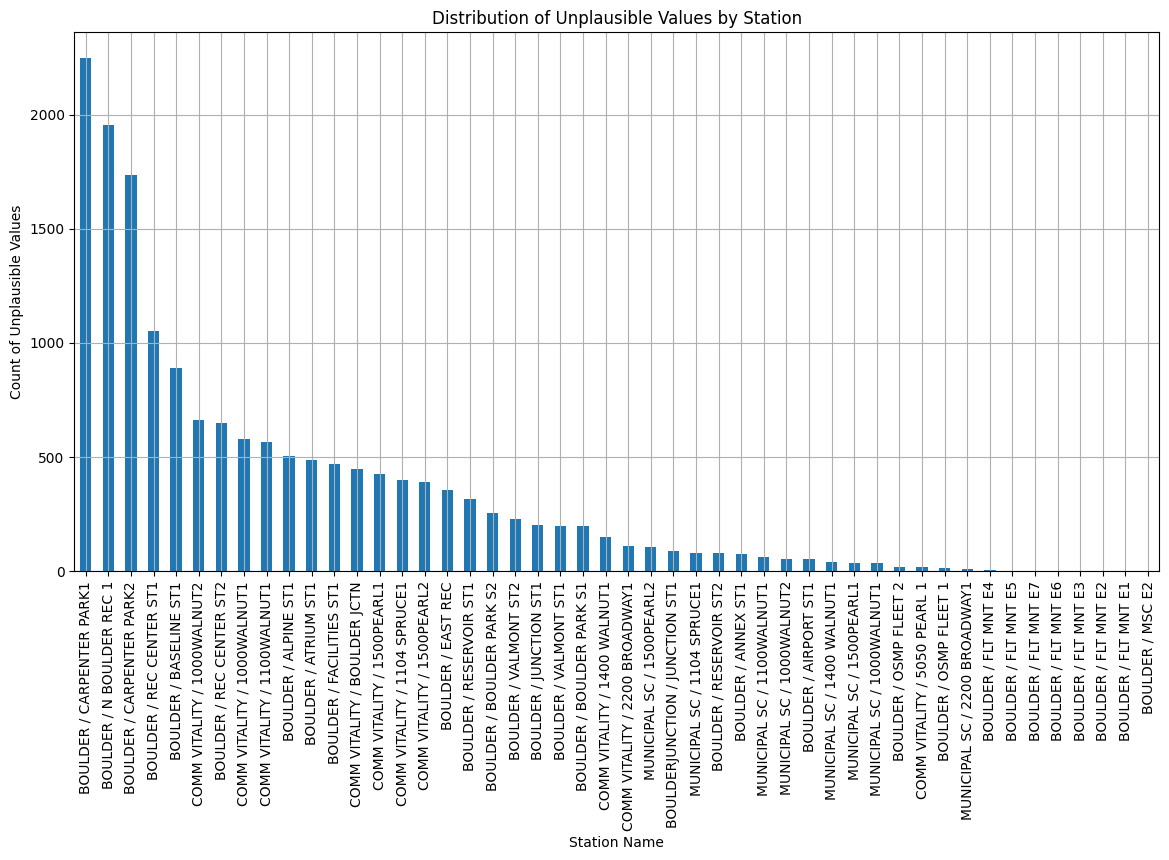

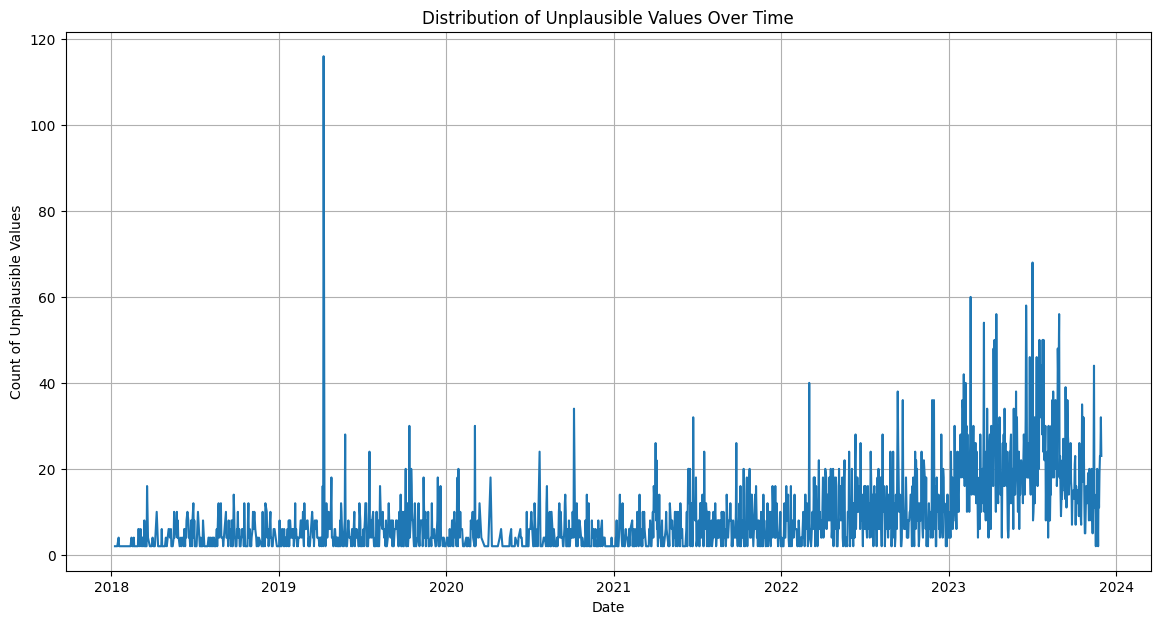

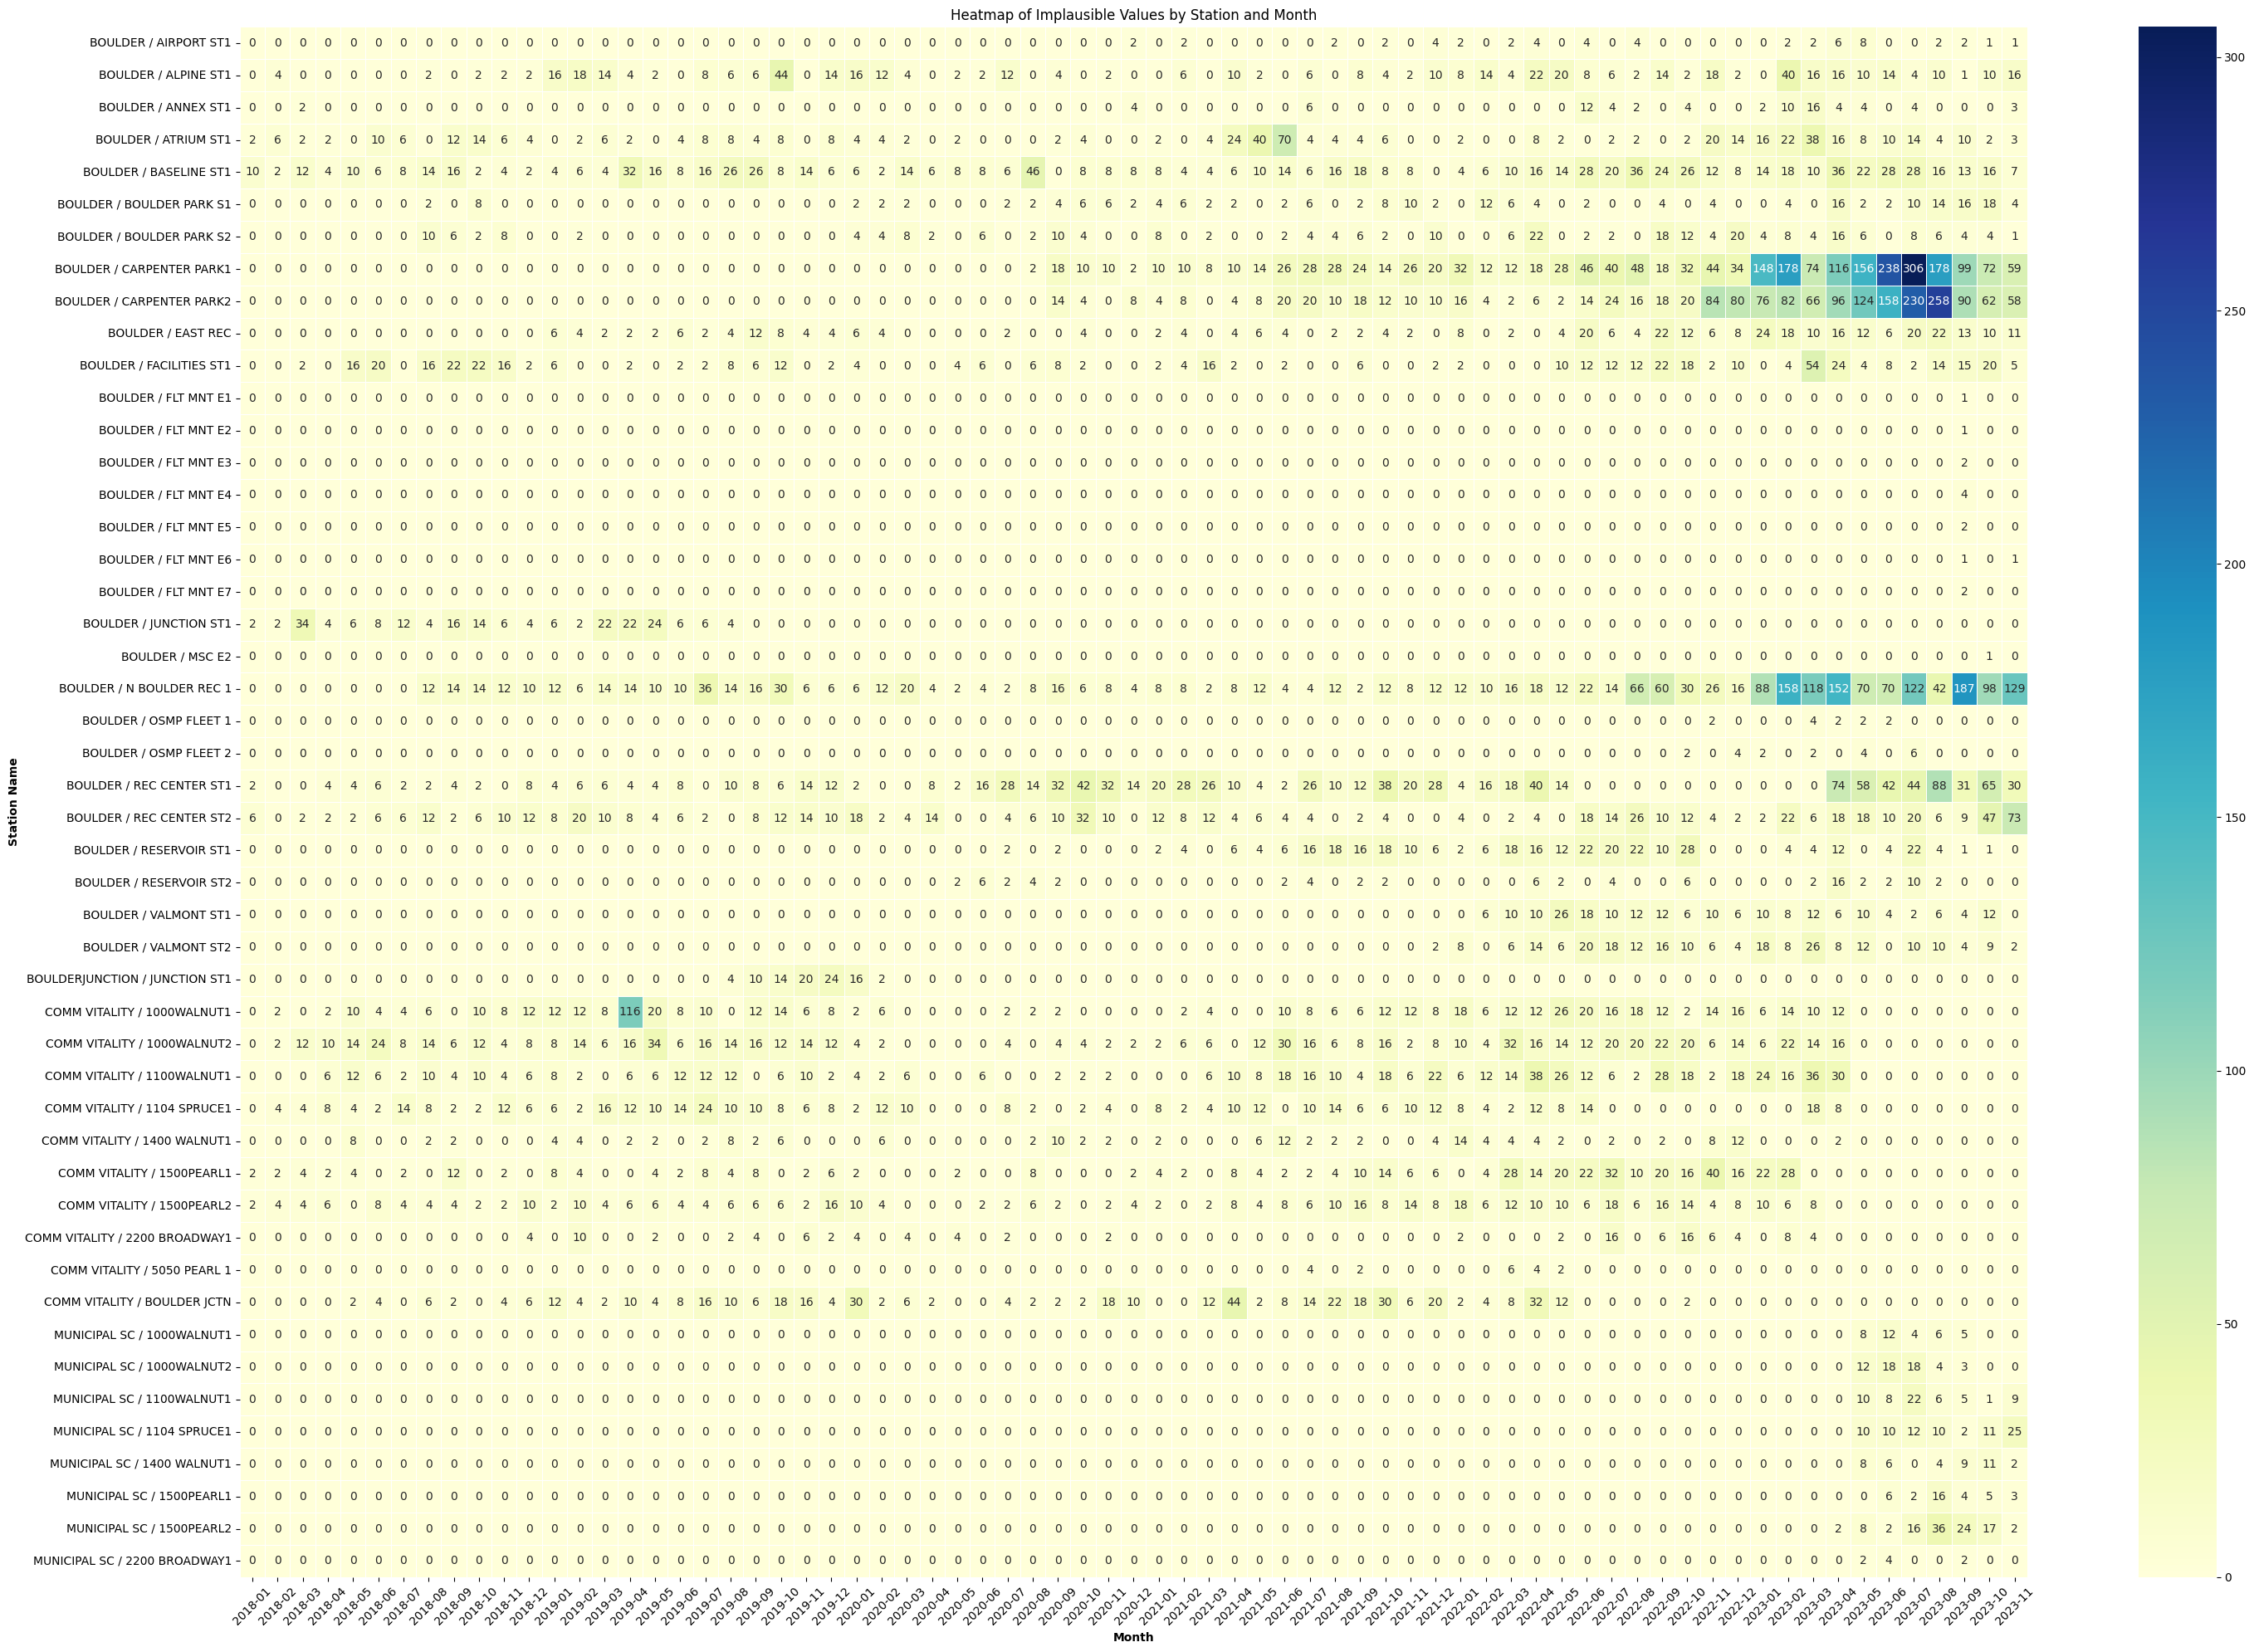

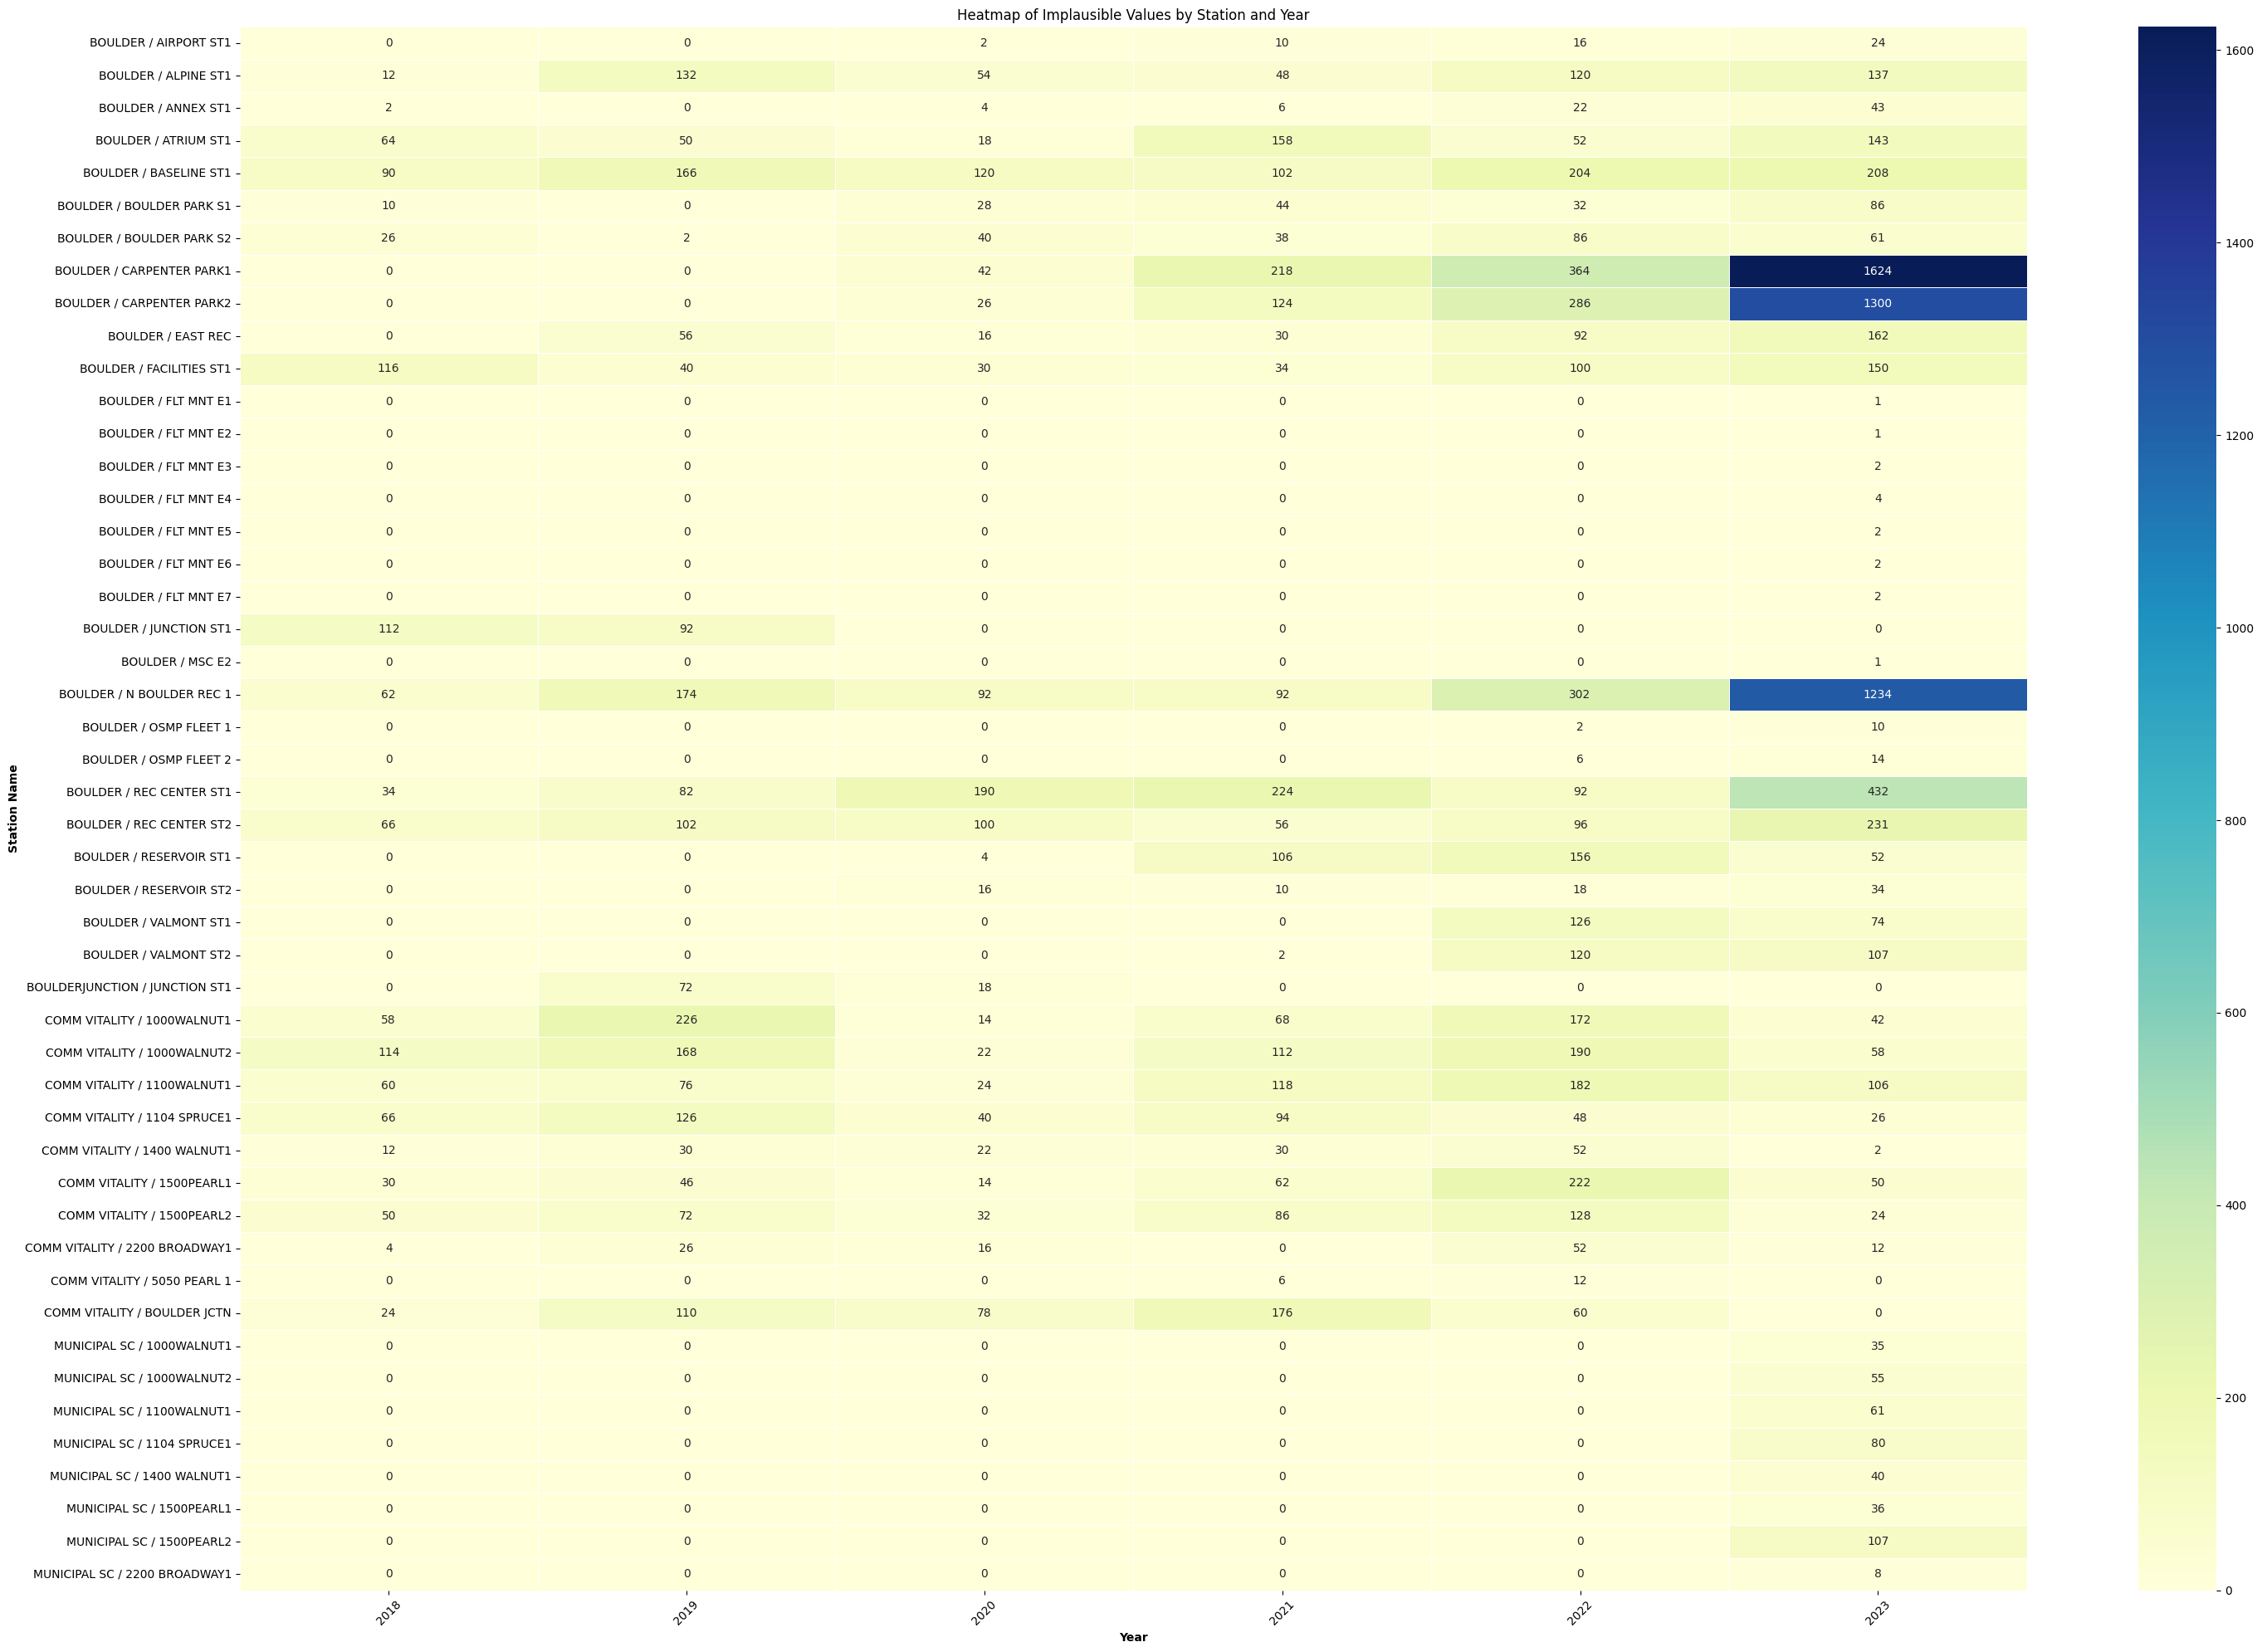

In [6]:
# Check for unplausible values in the dataframe
df_unplausible_values = df_formatted[
    (df_formatted["Energy__kWh_"] <= 0) |
    (df_formatted["GHG_Savings__kg_"] <= 0) |
    (df_formatted["Gasoline_Savings__gallons_"] <= 0) |
    (df_formatted["Charging_Time__hh_mm_ss_"] == "0:00:00")
]

# Print counts of unplausible values for each condition
print(df_formatted[df_formatted["Energy__kWh_"] <= 0].count())
print(df_formatted[df_formatted["GHG_Savings__kg_"] <= 0].count())
print(df_formatted[df_formatted["Gasoline_Savings__gallons_"] <= 0].count())
print(df_formatted[df_formatted["Charging_Time__hh_mm_ss_"] == "0:00:00"].count())
print(df_unplausible_values.count())

# Plot distribution of unplausible values by station
plt.figure(figsize=(14, 7))
df_unplausible_values['Station_Name'].value_counts().plot(kind='bar')
plt.title('Distribution of Unplausible Values by Station')
plt.xlabel('Station Name')
plt.ylabel('Count of Unplausible Values')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Plot distribution of unplausible values over time
plt.figure(figsize=(14, 7))
df_unplausible_values.groupby(df_unplausible_values['Start_Date___Time'].dt.date).size().plot(kind='line')
plt.title('Distribution of Unplausible Values Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Unplausible Values')
plt.grid(True)
plt.show()

# Add month and year columns for heatmap plotting
df_unplausible_values['Month'] = df_unplausible_values['Start_Date___Time'].dt.to_period('M')
df_unplausible_values['Year'] = df_unplausible_values['Start_Date___Time'].dt.to_period('Y')

# Pivot table to get unplausible values per station and month
heatmap_data_month = df_unplausible_values.pivot_table(
    index='Station_Name',
    columns='Month',
    values='Start_Date___Time',
    aggfunc='count',
    fill_value=0
)

# Plotting monthly heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(heatmap_data_month, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title('Heatmap of Implausible Values by Station and Month')
plt.xlabel('Month',fontweight = 'bold')
plt.ylabel('Station Name',fontweight = 'bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pivot table to get unplausible values per station and year
heatmap_data_year = df_unplausible_values.pivot_table(
    index='Station_Name',
    columns='Year',
    values='Start_Date___Time',
    aggfunc='count',
    fill_value=0
)

# Plotting yearly heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(heatmap_data_year, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title('Heatmap of Implausible Values by Station and Year')
plt.xlabel('Year',fontweight = 'bold')
plt.ylabel('Station Name',fontweight = 'bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<a id="distribution_of_mdt_and_mst_timezone_datapoints"></a>
## Distribution of MDT and MST Timezone Datapoints

Time Zone Assignment Issues

- **Observation**: The assignment of the time zones of the data points appears to be incorrectly distributed.
- **Details**: As Boulder has the same local time zome, the different timezones refers to summer and winter time.
- **Note**: The accuracy needs to be verified by the data collectors to correctly handle the time stamps.


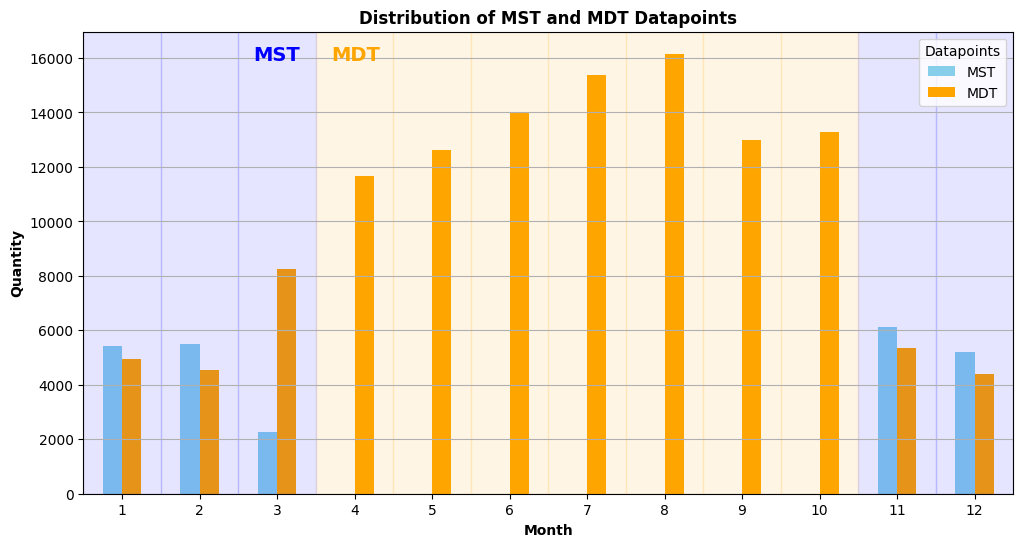

In [7]:
# Filter data points for "MST" and "MDT" time zones
df_mst = df_formatted[df_formatted['Start_Time_Zone'] == 'MST'].copy()
df_mdt = df_formatted[df_formatted['Start_Time_Zone'] == 'MDT'].copy()

# Extract the month from the start date
df_mst['Start_Date_Month'] = df_mst['Start_Date___Time'].dt.month
df_mdt['Start_Date_Month'] = df_mdt['Start_Date___Time'].dt.month

# Group by month to count data points
mst_monthly_distribution = df_mst.groupby('Start_Date_Month').size()
mdt_monthly_distribution = df_mdt.groupby('Start_Date_Month').size()

# Combine "MST" and "MDT" distributions into a single dataframe for plotting
distribution = pd.DataFrame({
    'MST': mst_monthly_distribution,
    'MDT': mdt_monthly_distribution
}).fillna(0)  # Fill NaN values with 0

# Plot the distribution of "MST" and "MDT" data points by month
ax = distribution.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'orange'])
plt.title('Distribution of MST and MDT Datapoints',fontweight = 'bold')
plt.xlabel('Month',fontweight = 'bold')
plt.xticks(rotation=0)
plt.ylabel('Quantity',fontweight = 'bold')
plt.grid(axis='y')
plt.legend(title='Datapoints')

# Add rectangles to display correct "MST" and "MDT" zones
for month in [11, 12, 1, 2, 3]:
    ax.add_patch(plt.Rectangle((month-1.5, 0), 1, ax.get_ylim()[1], color='blue', alpha=0.1))
ax.text(2, ax.get_ylim()[1]*0.95, 'MST', color='blue', ha='center', va='center', fontsize=14, weight='bold')
for month in [4, 5, 6, 7, 8, 9, 10]:
    ax.add_patch(plt.Rectangle((month-1.5, 0), 1, ax.get_ylim()[1], color='orange', alpha=0.1))
ax.text(2.7, ax.get_ylim()[1]*0.95, 'MDT', color='orange', ha='left', va='center', fontsize=14, weight='bold')

# Show the plot
plt.show()

<a id="remove_implausible_values"></a>
# Remove Implausible Values

Removal of Implausible Data

- **Precondition**: The above problems should first be clarified to correctly remove all implausible data.
- **Action**: Only the obviously incorrect data points are removed here -> Null values and implaubile timestamps.

In [8]:
# Create a copy of the formatted dataframe for plausibility checks
df_check_plausibility = df_formatted.copy()

# Drop rows with any null values
initial_count = len(df_check_plausibility)
df_check_plausibility.dropna(inplace=True)
null_dropped_count = initial_count - len(df_check_plausibility)

# Calculate derived values
df_check_plausibility['Calculated_Duration'] = df_check_plausibility['End_Date___Time'] - df_check_plausibility['Start_Date___Time']

# Check if Start times are before End times
df_check_plausibility['Start_Before_End'] = df_check_plausibility['Start_Date___Time'] < df_check_plausibility['End_Date___Time']

# Check if charging time is less than or equal to the total duration
df_check_plausibility['Charging_Time_Valid'] = df_check_plausibility['Charging_Time__hh_mm_ss_'] <= df_check_plausibility['Total_Duration__hh_mm_ss_']

# Filter out invalid rows based on the conditions
filtered_count = len(df_check_plausibility)
df_filtered = df_check_plausibility[
    df_check_plausibility['Start_Before_End'] &
    df_check_plausibility['Charging_Time_Valid']
]
removed_count = filtered_count - len(df_filtered)

# Count of each invalid type before filtering
df_invalid_counts = pd.DataFrame({
    'Error Type': ['Start Time > End Time', 'Charging Time > Duration'],
    'Count': [(~df_check_plausibility['Start_Before_End']).sum(),
              (~df_check_plausibility['Charging_Time_Valid']).sum()]
})

# Display the number of removed data points
print(f"Number of data points removed due to null values: {null_dropped_count}")
print(f"Number of data points removed due to invalid conditions: {removed_count}")





Number of data points removed due to null values: 4
Number of data points removed due to invalid conditions: 1535


<a id="statistical_values"></a>
# Statistical Values

In [9]:
# Calculate statistical summary for selected columns
statistical_filtered_data = df_filtered[['Charging_Time__hh_mm_ss_','Energy__kWh_', 'GHG_Savings__kg_', 'Gasoline_Savings__gallons_']].describe().round(2)
display(statistical_filtered_data)


Charging_Time__hh_mm_ss_  Energy__kWh_  GHG_Savings__kg_  \
count                     146597     146597.00         146597.00   
mean   0 days 01:44:58.229875099          8.55              5.36   
std    0 days 01:41:26.052021608          8.88              6.00   
min              0 days 00:00:00          0.00              0.00   
25%              0 days 00:42:31          2.92              1.66   
50%              0 days 01:24:02          6.29              3.75   
75%              0 days 02:16:13         11.46              6.98   
max              2 days 02:24:01         92.69             65.81   

       Gasoline_Savings__gallons_  
count                   146597.00  
mean                         1.07  
std                          1.11  
min                          0.00  
25%                          0.37  
50%                          0.79  
75%                          1.44  
max                         11.63

<a id="plots"></a>
# Plots

<a id="local_distribution_of_charging_station"></a>
## Local Distribution of Charging Station

<a id="map"></a>
### Map

- **Function Purpose**: To visualize the local distribution of charging stations.
- **Application**: Can be used to identify and draw local dependencies in later plots if interesting observations are made.

In [10]:
# Initialize geolocator
geolocator = Nominatim(user_agent="ev_station_locator")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.5)

# Function to get longitude and latitude from an address
def get_coordinates(address):
    try:
        location = geocode(address)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return None, None

# Function for small jitter if station are located at the same address
def add_jitter(lat, lon, scale=0.0001):
    lat_jittered = lat + np.random.uniform(-scale, scale)
    lon_jittered = lon + np.random.uniform(-scale, scale)
    return lat_jittered, lon_jittered

# Callback function to search a specific station
def search_station(b):
    station_name = search_box.value
    if station_name in markers:
        marker = markers[station_name]
        new_map_center = marker.location
        # Create a new map centered on the searched station
        new_map = folium.Map(location=new_map_center, zoom_start=20)
        for m in markers.values():
            m.add_to(new_map)
        clear_output(wait=True)
        display(search_box, search_button)
        display(new_map)
    else:
        print(f"Station '{station_name}' not found.")

# Iterate through addresses to get coordinates -> reset_index necessary, otherwise merging on wrong index below
unique_addresses = df_filtered[['Station_Name', 'Full_Address']].drop_duplicates().reset_index(drop=True)

# Collect coordinates and log addresses without coordinates
coordinates = []
no_coordinates = []

for _, row in unique_addresses.iterrows():
    lat, lon = get_coordinates(row['Full_Address'])
    if lat is not None and lon is not None:
        coordinates.append((lat, lon))
    else:
        no_coordinates.append((row['Station_Name'], row['Full_Address']))

# Display addresses with no coordinates
if no_coordinates:
    print("Addresses where no coordinates could be determined:")
    for station_name, address in no_coordinates:
        print(f"Station: {station_name}, Address: {address}")

# Create new DataFrame for map
df_geocoded = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'])
df_geocoded['Station_Name'] = unique_addresses['Station_Name']
df_geocoded['Full_Address'] = unique_addresses['Full_Address']

# Remove datapoints without coordinates
df_geocoded = df_geocoded.dropna(subset=['Latitude', 'Longitude']).reset_index(drop=True)

# Create map
map_center = [df_geocoded['Latitude'].mean(), df_geocoded['Longitude'].mean()]
ev_map = folium.Map(location=map_center, zoom_start=12)

# Add marker for every station
markers = {}
for _, row in df_geocoded.iterrows():
    lat_jittered, lon_jittered = add_jitter(row['Latitude'], row['Longitude'])
    marker = folium.Marker(
        location=[lat_jittered, lon_jittered],
        popup=f"{row['Station_Name']}",
    ).add_to(ev_map)
    markers[row['Station_Name']] = marker

search_box = widgets.Text(
    value='',
    placeholder='Enter station name',
    description='Search:',
    disabled=False
)
search_button = widgets.Button(
    description='Zoom to Station',
    disabled=False,
    button_style='',
    tooltip='Click to zoom to the station',
    icon='search'
)
search_button.on_click(search_station)

display(search_box, search_button)

# Display map
display(ev_map)



Addresses where no coordinates could be determined:
Station: COMM VITALITY / 1100WALNUT1, Address: 1100 Walnut, Boulder, Colorado, 80302
Station: MUNICIPAL SC / 1100WALNUT1, Address: 1100 Walnut, Boulder, Colorado, 80302


Text(value='', description='Search:', placeholder='Enter station name')

Button(description='Zoom to Station', icon='search', style=ButtonStyle(), tooltip='Click to zoom to the statio…

<a id="transactions"></a>
## Transactions

- **Definition**: Each plugging into the charging station counts as a transaction, regardless of whether charging occurs.


<a id="transactions_per_month"></a>
### Transactions per Month

Trend in Transactions

- **Observation**: A clear drop in transactions in 2020.
  - **Reason**: Can be attributed to the pandemic and the associated curfews.
- **Subsequent Increase**: An increase in transactions in later periods.
  - **Reason**: Can be attributed to the increasing number of electric cars and the provided subsidies by the government for promotion purpose.


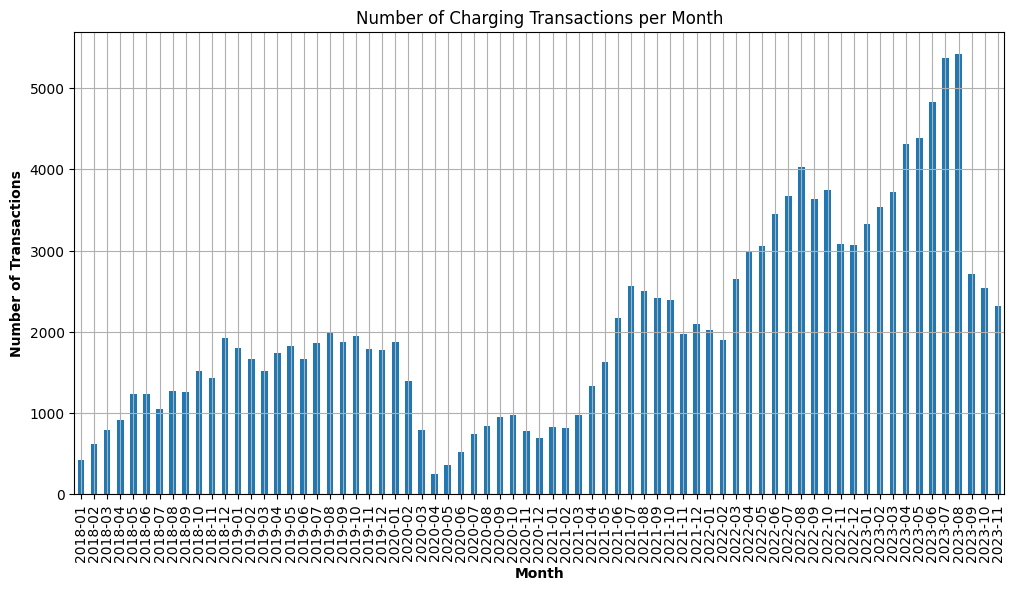

In [11]:
# Extract the month from the start date to create a transaction date period
df_filtered['Transaction_Date'] = df_filtered['Start_Date___Time'].dt.to_period('M')

# Count the number of transactions per month and sort by date in ascending order
monthly_counts = df_filtered['Transaction_Date'].value_counts().sort_index(ascending=True)

# Plot the number of charging transactions per month
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar') 
plt.title('Number of Charging Transactions per Month')  
plt.xlabel('Month', fontweight='bold')  
plt.ylabel('Number of Transactions', fontweight='bold')   
plt.grid(True)  
plt.show()  



<a id="transactions_per_hour"></a>
### Transactions per Hour

Transaction Timing

- **Observation**: A large proportion of transactions occur during the day.
  - **Reason**: People charge their cars while shopping, working, etc.
- **Nighttime Transactions**: Transactions decrease during the night.
  - **Clarification**: This concerns the number of transactions, not the loading quantity.

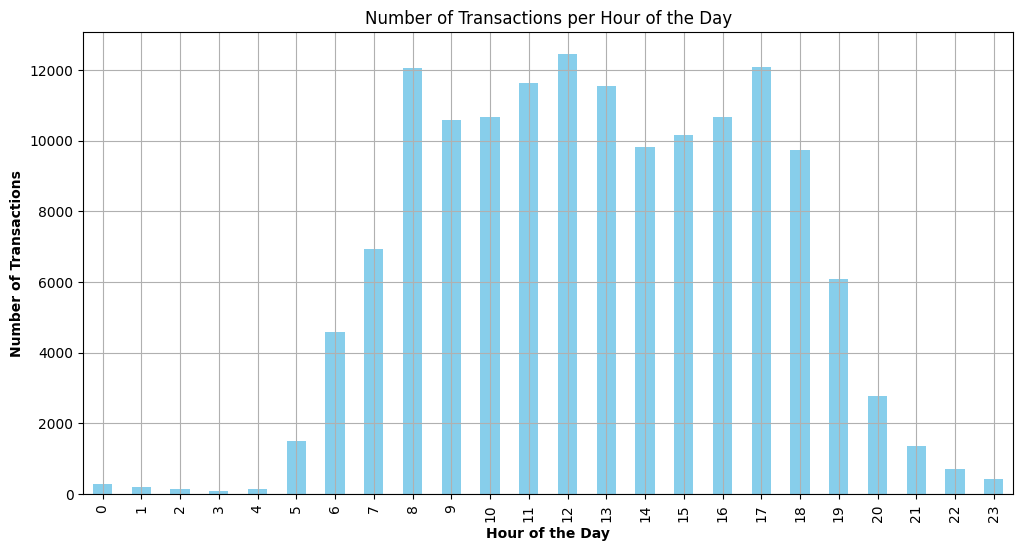

In [12]:
# Count the number of transactions per hour of the day and sort by hour in ascending order
hourly_counts = df_filtered['Start_Date___Time'].dt.hour.value_counts().sort_index()

# Plot the number of transactions per hour of the day
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Transactions per Hour of the Day')
plt.xlabel('Hour of the Day', fontweight = 'bold')
plt.ylabel('Number of Transactions', fontweight = 'bold')
plt.grid(True)
plt.show()


<a id="charging_time"></a>
## Charging Time

<a id="duration_vs_charging_time"></a>
### Duration vs. Charging Time

Public Charging Station Usage

- **Observation**: Cars are sometimes plugged into the charging stations for a very long time without actually charging.
- **Impact**: This behavior blocks public charging stations.
- **Suggestion**: There is room for improvement in managing the usage of public charging stations.

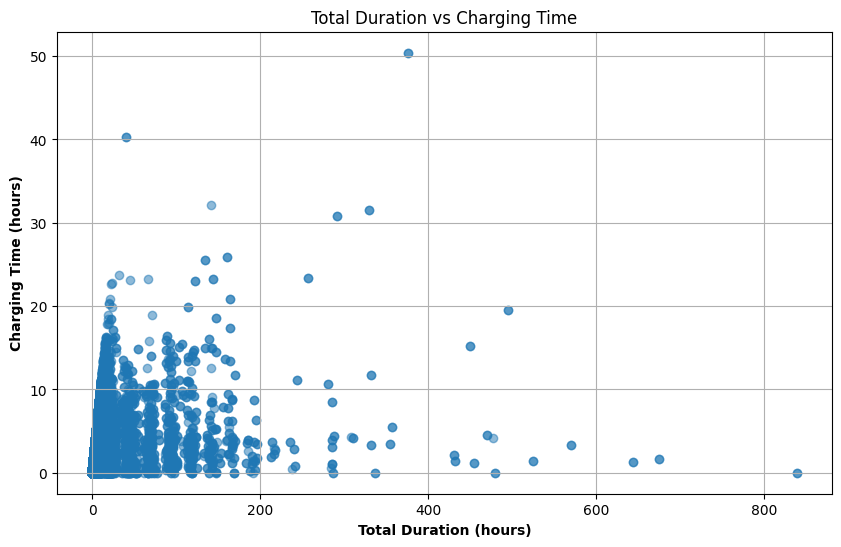

In [13]:
# Plot total duration vs charging time
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Total_Duration__hh_mm_ss_'].dt.total_seconds()/3600, df_filtered['Charging_Time__hh_mm_ss_'].dt.total_seconds()/3600, alpha=0.5)
plt.title('Total Duration vs Charging Time')
plt.xlabel('Total Duration (hours)',fontweight = 'bold')
plt.ylabel('Charging Time (hours)',fontweight = 'bold')
plt.grid(True)
plt.show()

<a id="average_charging_time_per_charging_cycle_by_starting_hour_of_the_day"></a>
### Average Charging Time per Charging Cycle by Starting Hour Of The Day

Charging Duration Patterns

- **Observation**: People charge their cars for a longer time on average in the evening and at night.
- **Daytime Charging**: Cars are charged for a shorter time on average during the day.
- **Explanation**: This fits with the explanation of charging while shopping, working, etc.

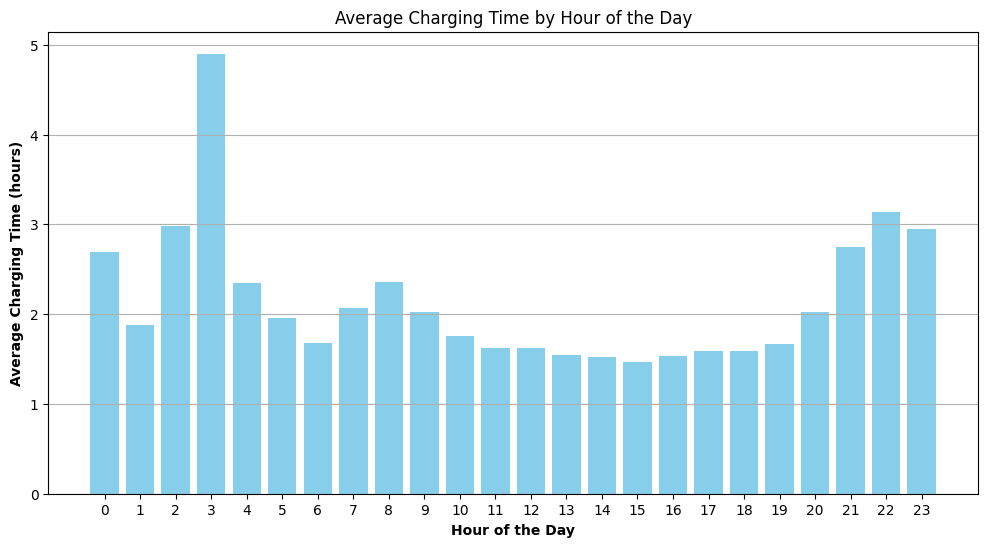

In [14]:
# Group by hour and calculate average charging duration
hourly_duration = df_filtered.groupby(df_filtered['Start_Date___Time'].dt.hour)['Charging_Time__hh_mm_ss_'].mean()
# hourly_duration = df_filtered.groupby(df_filtered['Start_Date___Time'].dt.hour)['Charging_Time__hh_mm_ss_'].median()

# Plotting the average charging duration by hour using a bar chart
plt.figure(figsize=(12, 6))
# Convert timedelta to hours for plotting
plt.bar(hourly_duration.index, hourly_duration.dt.total_seconds()/3600, color='skyblue')
plt.title('Average Charging Time by Hour of the Day')
plt.xlabel('Hour of the Day',fontweight = 'bold')
plt.ylabel('Average Charging Time (hours)',fontweight = 'bold')
plt.xticks(hourly_duration.index)
plt.grid(axis='y')
plt.show()

<a id="average_idle_charging_and_not_connected_time_distribution_over_the_hours_of_the_day"></a>
### Average Idle, Charging and Not Connected Time Distribution Over the Hours of the Day

Idling and Charging Patterns

- **Observation**: Idling hours during the night are very high.
  - **Reason**: Cars are plugged in for longer during the night even though they are already fully charged.
- **Daytime Idling**: Idle times naturally decrease during the day.
- **Daytime Charging**: Average charging hours adapt to the profile of PV generation, which is initially positive.
- **Additional Insight**: 
  - There is still potential for more charging hours during the day.
  - This is evident in the lower graph, indicating room for improvement.

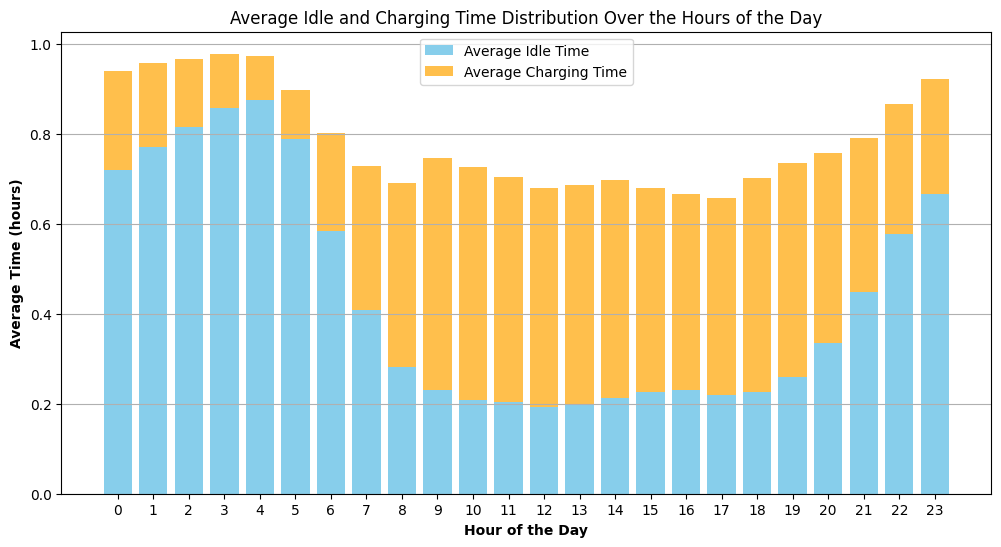

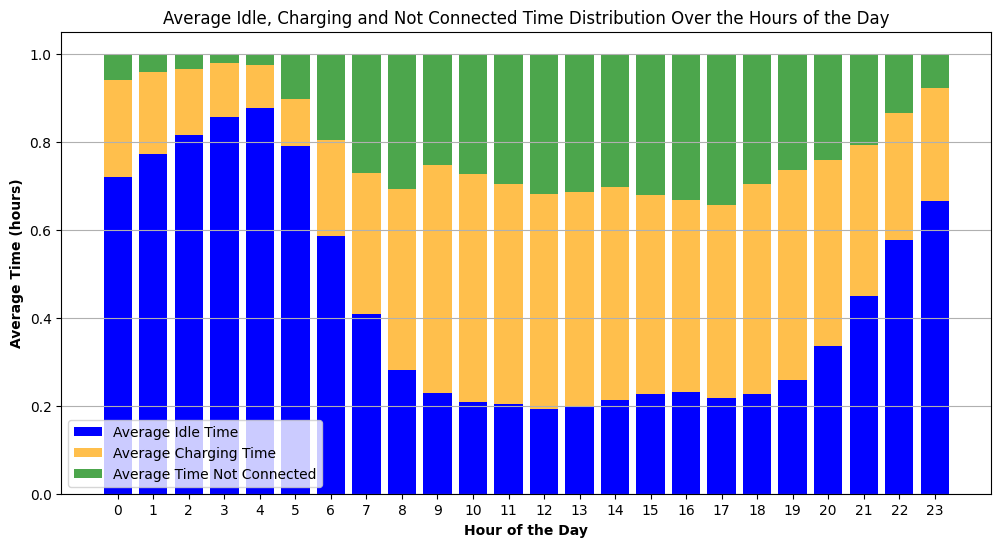

In [15]:
df_filtered_new = df_filtered.copy()

# Calculate idle and charging time
df_filtered_new['Total_Duration'] = pd.to_timedelta(df_filtered_new['Total_Duration__hh_mm_ss_'])
df_filtered_new['Charging_Time'] = pd.to_timedelta(df_filtered_new['Charging_Time__hh_mm_ss_'])
df_filtered_new['Idle_Time'] = df_filtered_new['Total_Duration'] - df_filtered_new['Charging_Time']

# Initialize arrays to hold time data per hour
idle_time_per_hour = np.zeros(24)
charging_time_per_hour = np.zeros(24)
record_count_per_hour = np.zeros(24)
not_connected_time_per_hour = np.zeros(24)

# Calculate distribution of idle and charging time for every hour
for _, row in df_filtered_new.iterrows():
    start = row['Start_Date___Time']
    end = row['End_Date___Time']
    idle_time = row['Idle_Time'].total_seconds() / 3600  # Convert idle time to hours
    charging_time = row['Charging_Time'].total_seconds() / 3600  # Convert charging time to hours

    current_time = start
    # Calculate charging time for each hour
    while charging_time > 0 and current_time < end:
        next_hour = current_time.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
        if next_hour > end:
            next_hour = end

        charging_time_for_current_hour = (next_hour - current_time).total_seconds() / 3600

        if charging_time < charging_time_for_current_hour:
            charging_time_for_current_hour = charging_time

        charging_time_per_hour[current_time.hour] += charging_time_for_current_hour
        record_count_per_hour[current_time.hour] += 1

        charging_time -= charging_time_for_current_hour
        current_time = next_hour

    # Calculate idle time for each hour
    while idle_time > 0 and current_time < end:
        next_hour = current_time.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
        if next_hour > end:
            next_hour = end

        idle_time_for_current_hour = (next_hour - current_time).total_seconds() / 3600

        if idle_time < idle_time_for_current_hour:
            idle_time_for_current_hour = idle_time

        idle_time_per_hour[current_time.hour] += idle_time_for_current_hour
        record_count_per_hour[current_time.hour] += 1

        idle_time -= idle_time_for_current_hour
        current_time = next_hour

# Calculate average idle, charging and not connected hours
average_idle_time_per_hour = np.divide(idle_time_per_hour, record_count_per_hour, out=np.zeros_like(idle_time_per_hour), where=record_count_per_hour != 0)
average_charging_time_per_hour = np.divide(charging_time_per_hour, record_count_per_hour, out=np.zeros_like(charging_time_per_hour), where=record_count_per_hour != 0)
average_not_connected_time_per_hour = 1 - (average_idle_time_per_hour + average_charging_time_per_hour)

# Create plot for average idle and charging time
plt.figure(figsize=(12, 6))
plt.bar(range(24), average_idle_time_per_hour, color='skyblue', label='Average Idle Time')
plt.bar(range(24), average_charging_time_per_hour, color='orange', alpha=0.7, label='Average Charging Time', bottom=average_idle_time_per_hour)
plt.xlabel('Hour of the Day', fontweight = 'bold')
plt.ylabel('Average Time (hours)', fontweight = 'bold')
plt.title('Average Idle and Charging Time Distribution Over the Hours of the Day')
plt.xticks(range(24))
plt.grid(axis='y')
plt.legend()
plt.show()

# Create plot for average idle, charging, and not connected time
plt.figure(figsize=(12, 6))
plt.bar(range(24), average_idle_time_per_hour, color='blue', label='Average Idle Time')
plt.bar(range(24), average_charging_time_per_hour, color='orange', alpha=0.7, label='Average Charging Time', bottom=average_idle_time_per_hour)
plt.bar(range(24), average_not_connected_time_per_hour, color='green', alpha=0.7, label='Average Time Not Connected', bottom=average_idle_time_per_hour + average_charging_time_per_hour)
plt.xlabel('Hour of the Day', fontweight = 'bold')
plt.ylabel('Average Time (hours)', fontweight = 'bold')
plt.title('Average Idle, Charging and Not Connected Time Distribution Over the Hours of the Day')
plt.xticks(range(24))
plt.grid(axis='y')
plt.legend()
plt.show()


<a id="energy_consumption"></a>
## Energy Consumption

<a id="total_energy_consumption_per_charging_station"></a>
### Total Energy Consumption per Charging Station

Usage of Charging Stations

- **Observation**: Some stations are used significantly more than others.
- **Example**: BOULDER / N BOULDER REC 1
  - **Location**: Directly next to North Boulder Recreation Center, a large shopping center.
  - **Explanation**: Proximity to a popular location explains the high frequency of use.


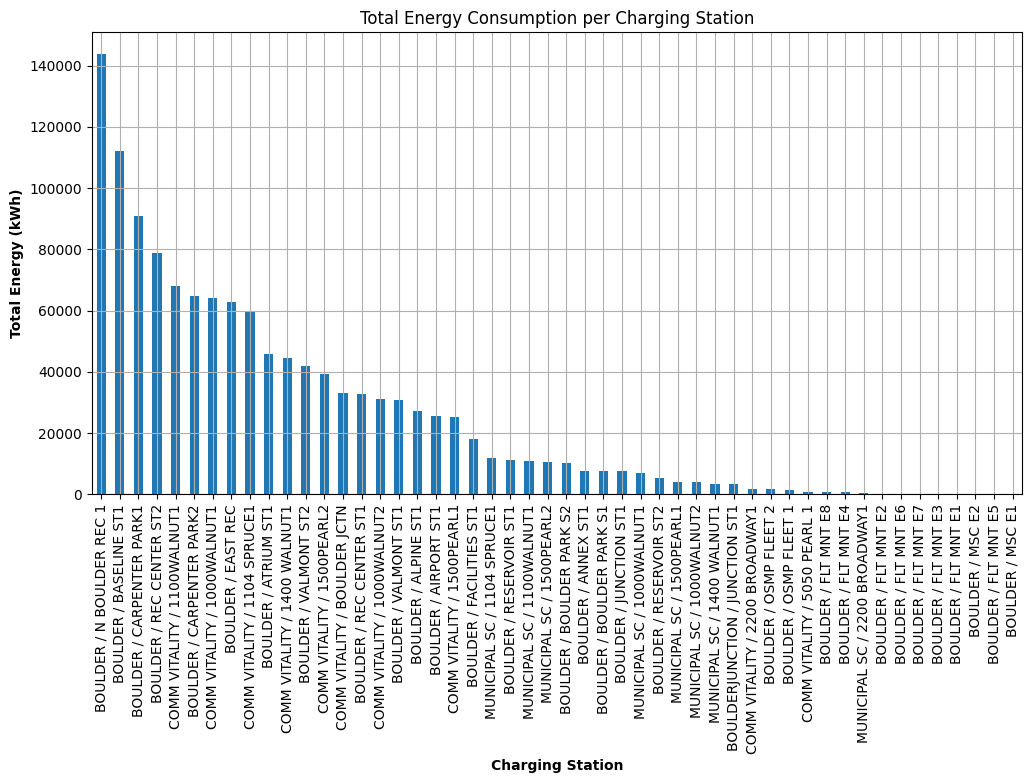

In [16]:
# Calculate total energy consumption per charging station
station_energy = df_filtered.groupby('Station_Name')['Energy__kWh_'].sum().sort_values(ascending=False)


# Plot the total energy consumption per charging station
plt.figure(figsize=(12, 6))
station_energy.plot(kind='bar')
plt.title('Total Energy Consumption per Charging Station')
plt.xlabel('Charging Station', fontweight = 'bold')
plt.ylabel('Total Energy (kWh)', fontweight = 'bold')
plt.grid(True)
plt.show()

<a id="energy_consumption_distribution"></a>
### Energy Consumption Distribution

Small Charging Cycles

- **Observation**: This plot shows that small charging cycles are performed more frequently.
- **Impact**: Beneficial for the lifespan of battery systems.
- **Explanation**: This can be attributed to typical scenarios like shopping, etc.

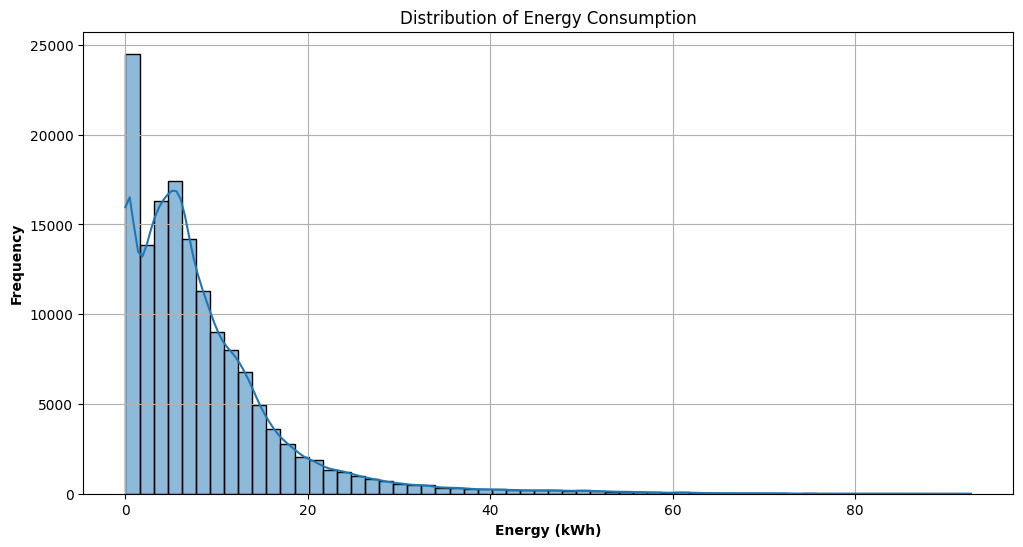

In [17]:
# Plot the distribution of energy consumption
plt.figure(figsize=(12, 6))
sns.histplot(data=df_filtered,x='Energy__kWh_', bins=60, kde=True)
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy (kWh)',fontweight = 'bold')
plt.ylabel('Frequency',fontweight = 'bold')
plt.grid(True)
plt.show()

<a id="consumption_by_day_of_the_week_and_hour"></a>
### Consumption by Day of the Week and hour

Energy Loading Patterns

- **Observation**: Most of the energy was loaded during lunchtime over the entire period, with a slight shift at the weekend.
- **Nighttime Charging**: The average amount of energy charged is higher at night.
  - **Reason**: Logical, as cars are connected for longer periods at night.

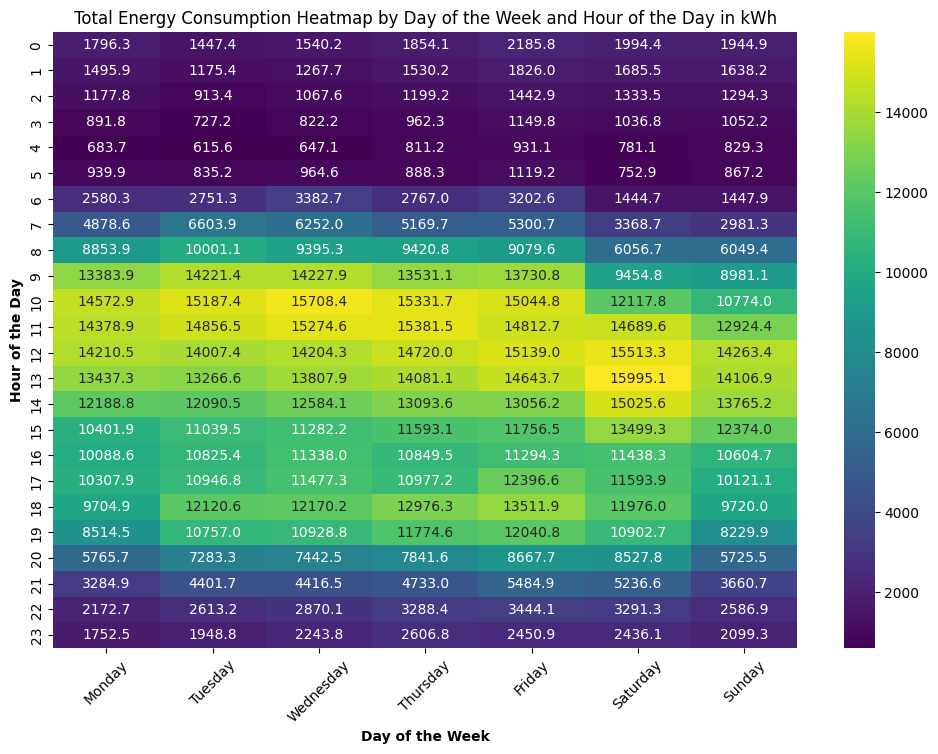

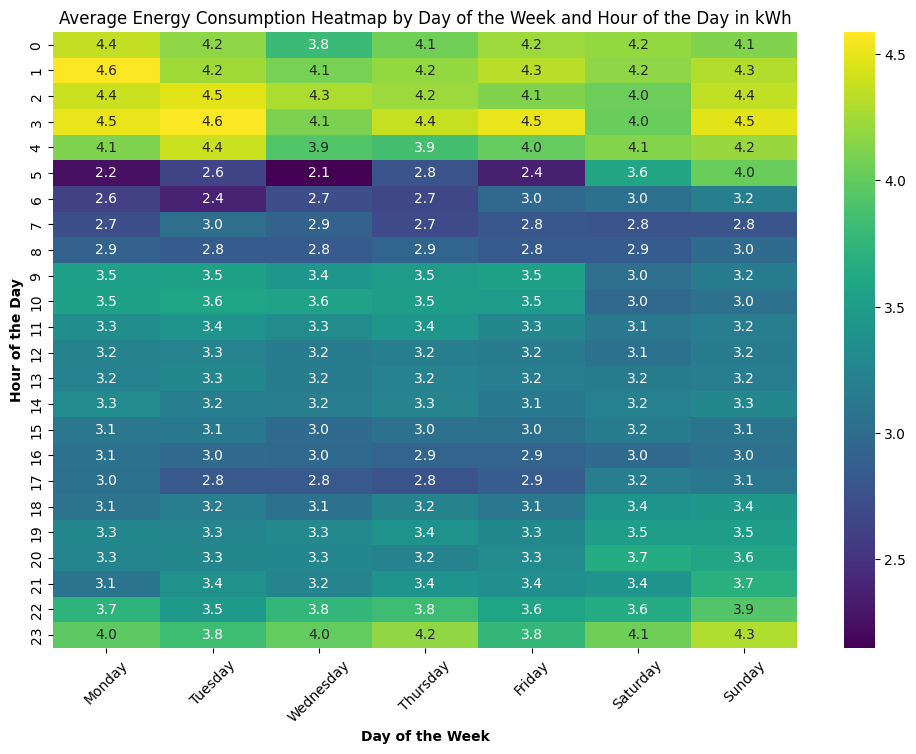

In [18]:
# Create copy
df_energy_consumption = df_filtered.copy()

# Ensure the start time and charging time are in the correct format
df_energy_consumption['Start_Date___Time'] = pd.to_datetime(df_energy_consumption['Start_Date___Time'])
df_energy_consumption['Charging_Time__hh_mm_ss_'] = pd.to_timedelta(df_energy_consumption['Charging_Time__hh_mm_ss_'])

# Create a new dataframe to expand the start times and charging times
expanded_rows = []

for _, row in df_energy_consumption.iterrows():
    start_time = row['Start_Date___Time']
    charging_time = row['Charging_Time__hh_mm_ss_']
    end_time = start_time + charging_time
    energy = row['Energy__kWh_']
    
    # Calculate total duration in hours
    total_duration_hours = charging_time.total_seconds() / 3600
    # Calculate energy per hour
    energy_per_hour = energy / total_duration_hours if total_duration_hours > 0 else 0
    
    current_time = start_time
    
    while current_time < end_time:
        # Calculate hour duration (handle partial hours)
        next_hour = (current_time + pd.Timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
        hour_end_time = min(next_hour, end_time)
        hour_duration = (hour_end_time - current_time).total_seconds() / 3600
        
        # Add energy consumption for current hour
        expanded_rows.append({
            'DayOfWeek': current_time.day_name(),
            'HourOfDay': current_time.hour,
            'Energy__kWh_': energy_per_hour * hour_duration
        })
        
        # Move to next hour
        current_time = hour_end_time

df_energy_consumption = pd.DataFrame(expanded_rows)

# Group by day of week and hour of day, summing energy consumption
heatmap_data_sum = df_energy_consumption.groupby(['DayOfWeek', 'HourOfDay'])['Energy__kWh_'].sum().unstack()

# Group by day of week and hour of day, calculating average energy consumption
heatmap_data_avg = df_energy_consumption.groupby(['DayOfWeek', 'HourOfDay'])['Energy__kWh_'].mean().unstack()

# Reorder days of week for better visualization
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data_sum = heatmap_data_sum.reindex(days_order)
heatmap_data_avg = heatmap_data_avg.reindex(days_order)

# Plotting heatmap for total energy consumption
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_sum.T, cmap='viridis', annot=True, fmt='.1f')
plt.title('Total Energy Consumption Heatmap by Day of the Week and Hour of the Day in kWh')
plt.xlabel('Day of the Week',fontweight = 'bold')
plt.ylabel('Hour of the Day',fontweight = 'bold')
plt.xticks(rotation=45)
plt.show()

# Plotting heatmap for average energy consumption
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_avg.T, cmap='viridis', annot=True, fmt='.1f')
plt.title('Average Energy Consumption Heatmap by Day of the Week and Hour of the Day in kWh')
plt.xlabel('Day of the Week',fontweight = 'bold')
plt.ylabel('Hour of the Day',fontweight = 'bold')
plt.xticks(rotation=45)
plt.show()


<a id="energy_consumption_over_the_years"></a>
### Energy Consumption over the Years

Changes in Statistical Measures

- **Observation**: Statistical measures have changed somewhat over the years.
- **Max Value of Energy Consumption**: The maximum values have increased over the years.
  

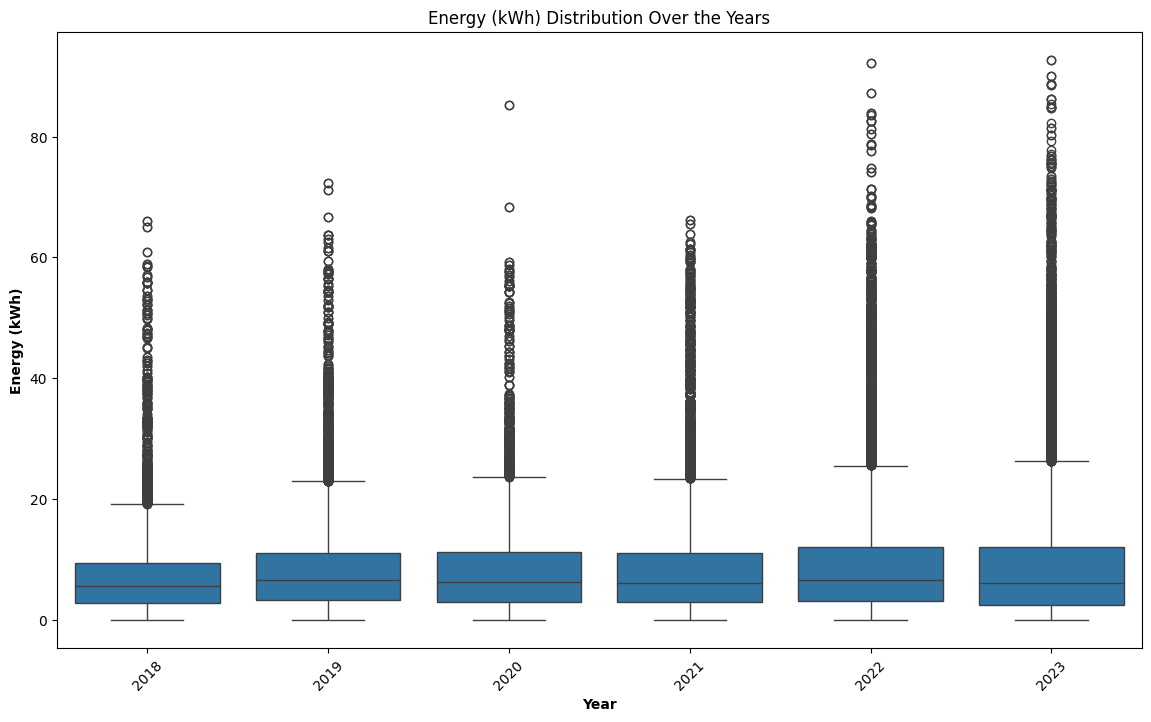

In [19]:
# Extract year from 'Start_Date___Time' column
df_boxplot = df_filtered.copy() 
df_boxplot['Year'] = df_boxplot['Start_Date___Time'].dt.year
# Plot boxplots for 'Energy__kWh_' over the years
plt.figure(figsize=(14, 8))
sns.boxplot(x='Year', y='Energy__kWh_', data=df_boxplot)
plt.title('Energy (kWh) Distribution Over the Years')
plt.xlabel('Year',fontweight = 'bold')
plt.ylabel('Energy (kWh)',fontweight = 'bold')
plt.xticks(rotation=45)
plt.show()


<a id="charging_time_vs_energy_consumption"></a>
### Charging Time vs. Energy Consumption

Linear Relationship in Charging Data

- **Observation**: Shows a linear relationship.
- **Scatter**: 
  - **Reason**: Due to different charging efficiencies or charging capacities of the charging stations.
  - **Additional Factor**: Variations among different car manufacturers.

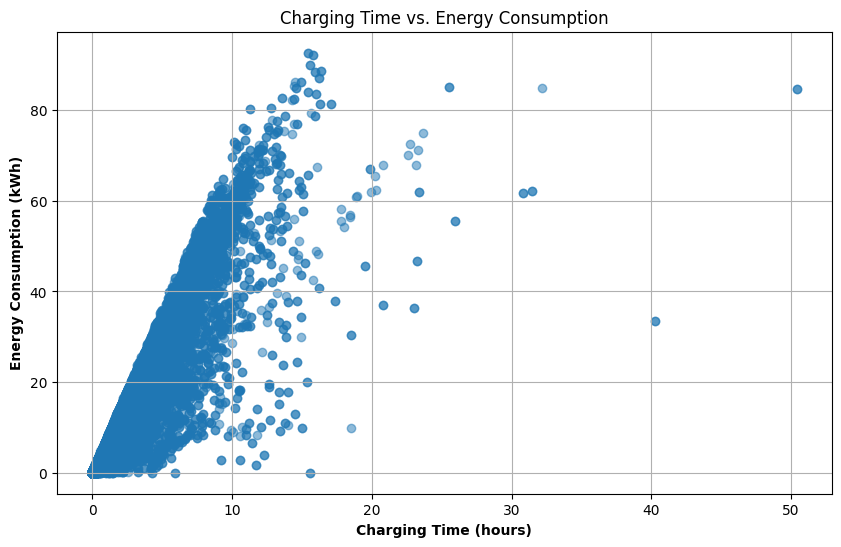

In [20]:
# Plot total duration vs charging time
plt.figure(figsize=(10, 6))
df_filtered['Charging_Time__hh_mm_ss_']
plt.scatter(df_filtered['Charging_Time__hh_mm_ss_'].dt.total_seconds()/3600, df_filtered['Energy__kWh_'], alpha=0.5)
plt.title('Charging Time vs. Energy Consumption')
plt.xlabel('Charging Time (hours)',fontweight = 'bold')
plt.ylabel('Energy Consumption (kWh)',fontweight = 'bold')
plt.grid(True)
plt.show()

<a id="emission_avoidance"></a>
## Emission Avoidance

<a id="annual_ghg_savings_over_the_year"></a>
### Annual GHG Savings Over the Year

Increase in GHG Savings

- **Observation**: GHG savings are rising sharply.
  - **Reason 1**: Increased number of electric cars caused by subsidies.
  - **Reason 2**: Specific GHG saving targets being set by the city.
- **Further Exploration**: More details can be explored on the [Boulder Community Greenhouse Gas Emissions page](https://bouldercolorado.gov/boulder-measures/community-greenhouse-gas-emissions).

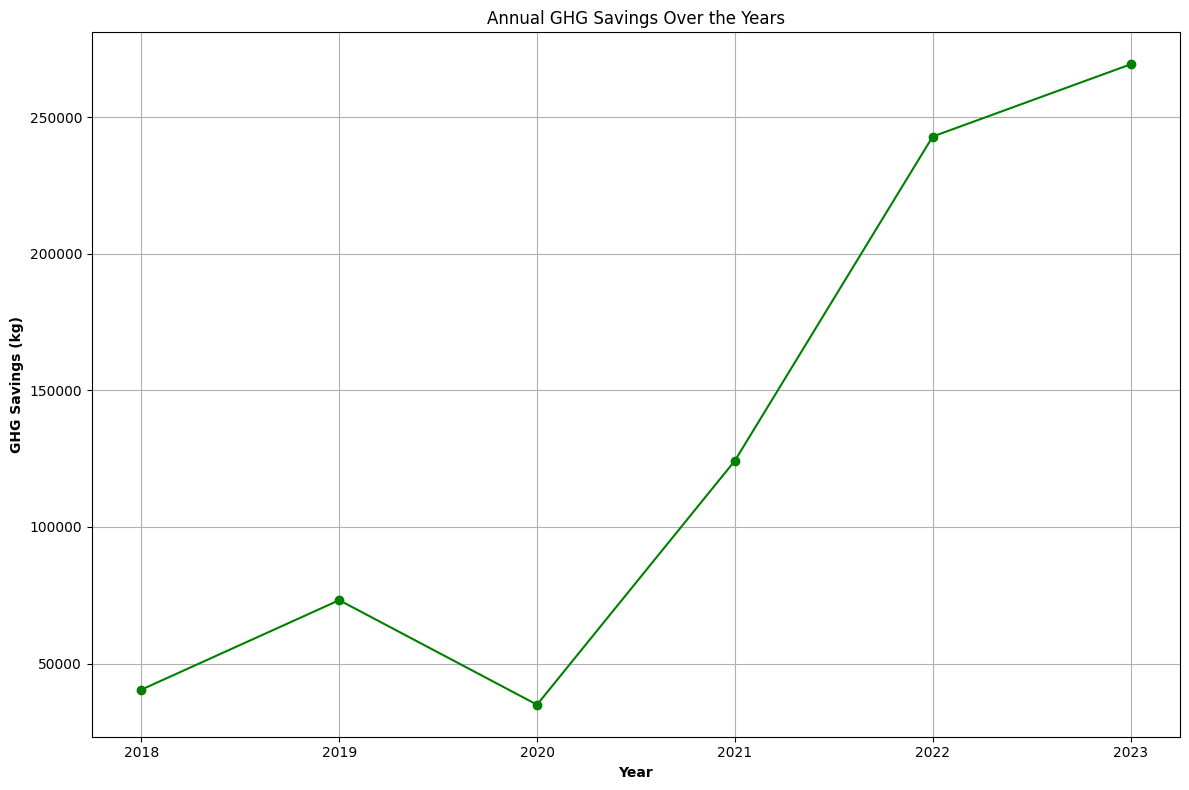

In [21]:
# Create copy
df_copy = df_filtered.copy()

# Extract year from 'Start_Date___Time'
df_copy['Year'] = df_copy['Start_Date___Time'].dt.year

# Group by year and sum the GHG Savings
yearly_ghg_savings = df_copy.groupby('Year')['GHG_Savings__kg_'].sum()

# Plot GHG Savings over the years
plt.figure(figsize=(12, 8))
plt.plot(yearly_ghg_savings.index, yearly_ghg_savings.values, marker='o', linestyle='-', color='green')
plt.title('Annual GHG Savings Over the Years')
plt.xlabel('Year',fontweight = 'bold')
plt.ylabel('GHG Savings (kg)',fontweight = 'bold')
plt.grid(True)
plt.xticks(yearly_ghg_savings.index)  # Ensure all years are shown
plt.tight_layout()
plt.show()


<a id="ghg_savings_vs_energy_consumption"></a>
### GHG Savings vs. Energy Consumption

- **Observation**: GHG savings have significantly increased since 2021 despite stable energy consumption.
- **Reason**: The increased GHG savings can be attributed to the higher number of electric vehicles, supported by subsidies, and specific GHG saving targets set by the city.

*Relationship with Xcel Energy Partnership*

- **Partnership Impact**: The partnership between the City of Boulder and Xcel Energy has been instrumental in achieving these GHG savings. This collaboration aims to expand access to clean, renewable power and enhance the energy system's resilience and reliability.
- **Goals and Achievements**:
  - **100% Renewable Electricity by 2030**: Both the city and Xcel Energy are working towards achieving 100% renewable electricity by 2030.
  - **Local Renewable Energy Generation**: The partnership has set a target of generating 100 megawatts of local renewable energy by 2030, which supports the community’s GHG reduction goals.

For more detailed information, you can explore the [Boulder Community Greenhouse Gas Emissions page](https://bouldercolorado.gov/boulder-measures/community-greenhouse-gas-emissions) and the [Xcel Energy Partnership overview](https://bouldercolorado.gov/projects/xcel-energy-partnership).


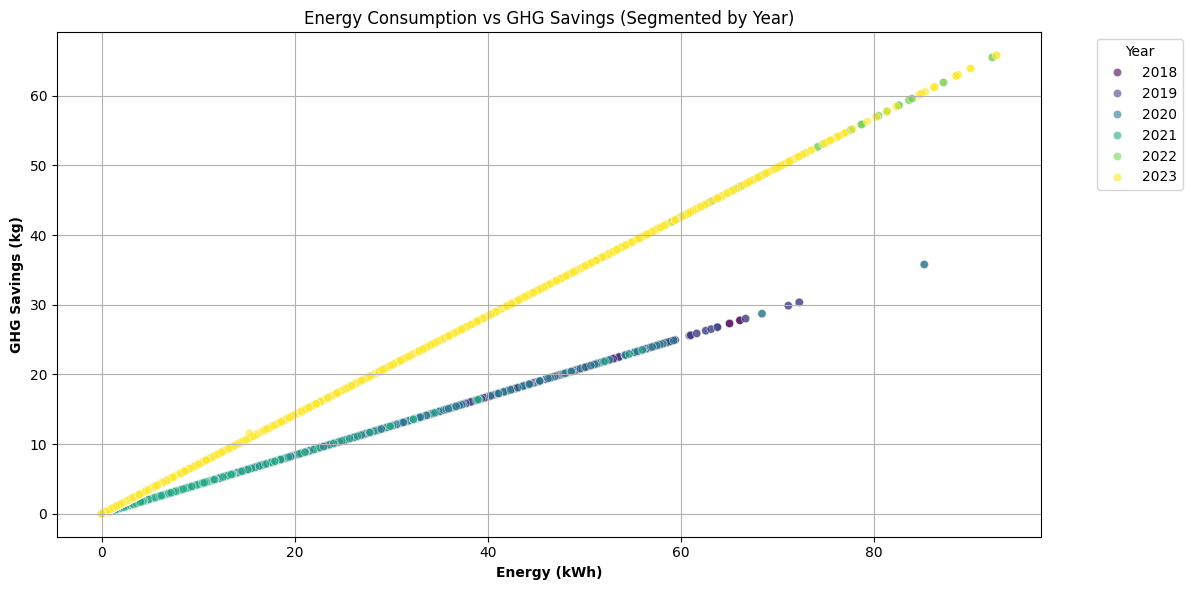

<Figure size 1400x800 with 0 Axes>

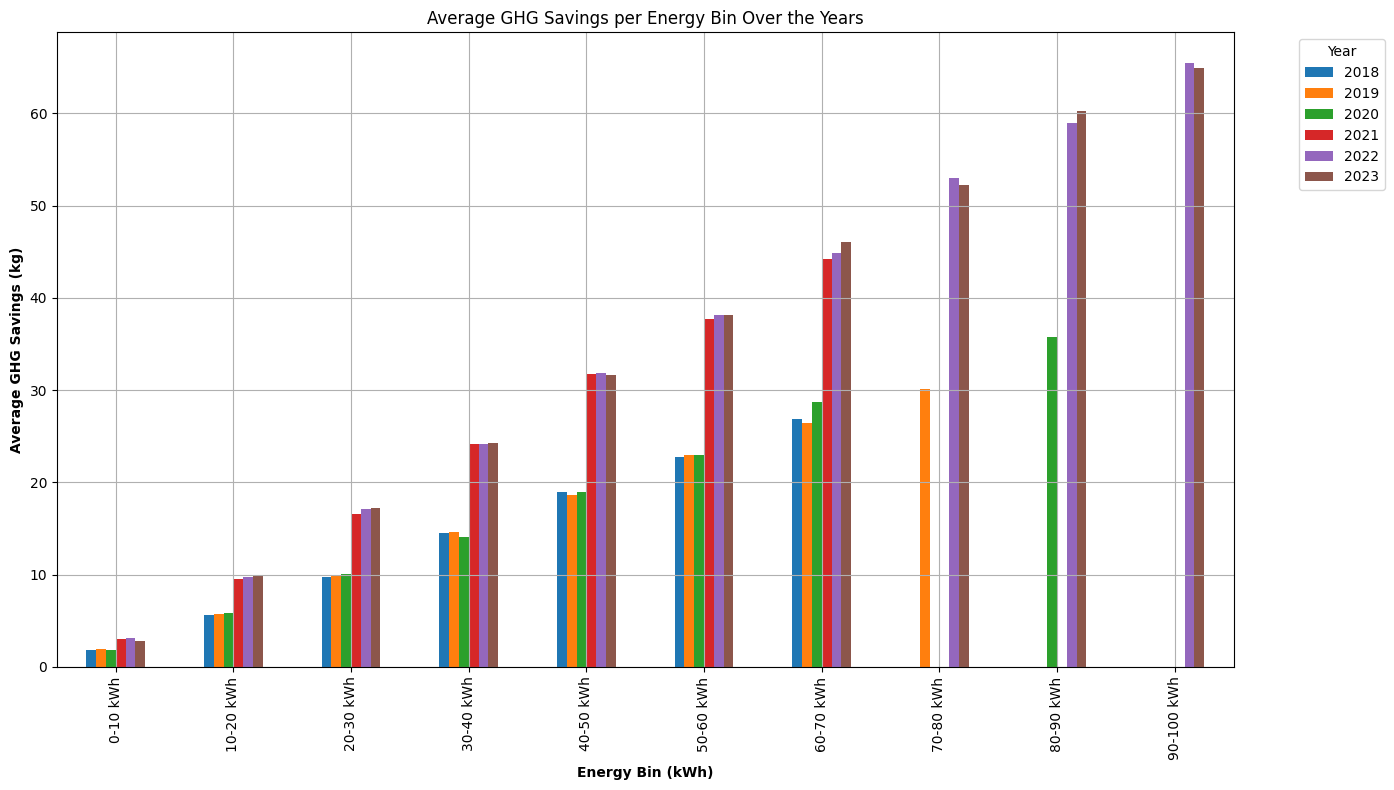

In [22]:
# Create copy
df_ghg_savings = df_filtered.copy()


# Extract the year from 'Start_Date___Time'
df_ghg_savings['Year'] = df_ghg_savings['Start_Date___Time'].dt.year

# Scatterplot with different colors for different years
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_ghg_savings, x='Energy__kWh_', y='GHG_Savings__kg_', hue='Year', palette='viridis', alpha=0.6)
plt.title('Energy Consumption vs GHG Savings (Segmented by Year)')
plt.xlabel('Energy (kWh)', fontweight ='bold')
plt.ylabel('GHG Savings (kg)', fontweight = 'bold')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Filter Data for years 2018 to 2023
df_ghg_savings = df_ghg_savings[(df_ghg_savings['Year'] >= 2018) & (df_ghg_savings['Year'] <= 2023)]

# Create energy intervals and labels (distance = 10 kWh)
bins = range(0, int(df_ghg_savings['Energy__kWh_'].max()) + 10, 10)
labels = [f'{i}-{i+10} kWh' for i in bins[:-1]]

# Split data into intervals
df_ghg_savings['Energy_Bin'] = pd.cut(df_ghg_savings['Energy__kWh_'], bins=bins, labels=labels, right=False)

# Calculate average per year and energy bin
avg_ghg_per_year = df_ghg_savings.groupby(['Year', 'Energy_Bin'])['GHG_Savings__kg_'].mean().reset_index()

# Create pivot table for better visualisation
pivot_data = avg_ghg_per_year.pivot(index='Energy_Bin', columns='Year', values='GHG_Savings__kg_')

# Plot average ghg savings per energy bin over the years
plt.figure(figsize=(14, 8))
pivot_data.plot(kind='bar', figsize=(14, 8))
plt.title('Average GHG Savings per Energy Bin Over the Years')
plt.xlabel('Energy Bin (kWh)', fontweight = 'bold')
plt.ylabel('Average GHG Savings (kg)', fontweight = 'bold')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

<a id="parameter_correlation"></a>
## Parameter Correlation

<a id="parameter_correlation_heatmap"></a>
### Correlation Heat Map

Heat Map Analysis

- **Observation**: The heat map shows the typical almost linear dependencies between variables such as charging time, energy consumption, GHG savings, and gasoline savings.
- **Connections**:
  - **Charging Time vs. Energy Consumption**: A strong linear relationship indicating that longer charging times result in higher energy consumption.
  - **GHG Savings and Gasoline Savings**: Both variables show a dependency on the energy consumed, illustrating the environmental benefits of reduced gasoline usage and increased GHG savings.
  - **Actual Charging Time vs. Duration Time**: The heat map also highlights the connection between the actual charging time and the duration time, showing how time management impacts charging efficiency and offers potential for additional GHG savings.


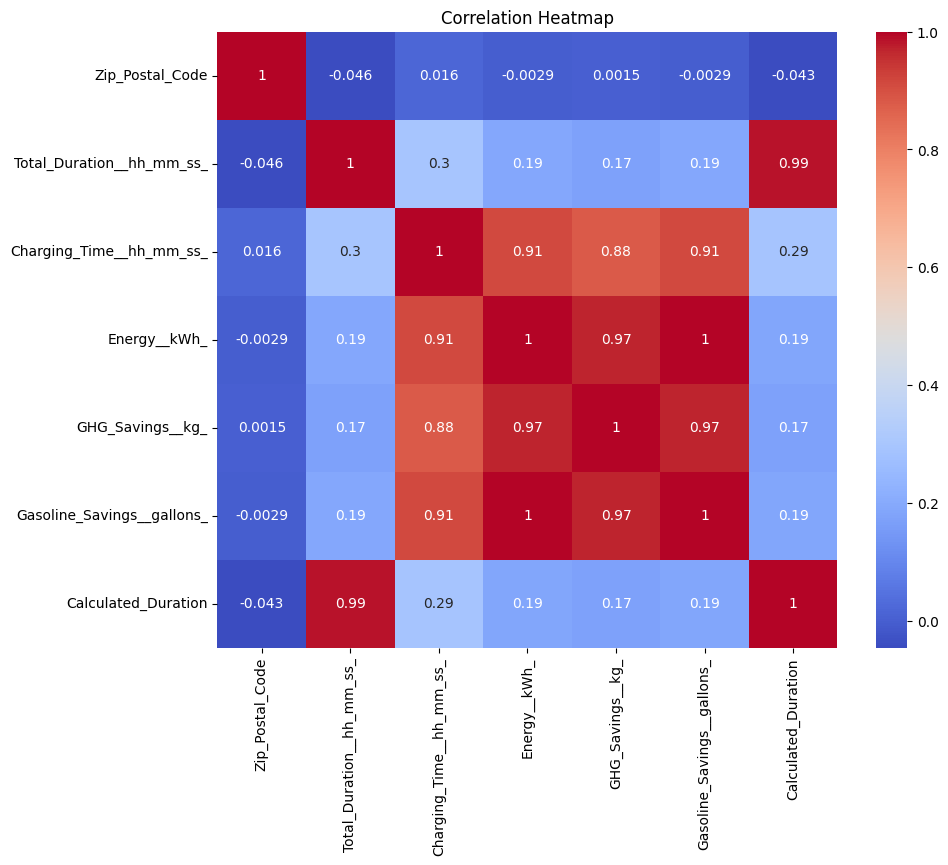

In [23]:
# Create DataFrame for correlation heatmap by selecting numerical columns
df_numerical_data = df_filtered.select_dtypes(include=['number']).drop(columns=['ObjectID', 'ObjectId2'])

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_numerical_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



